In [1]:
import os
import math
import numpy as np
import pandas as pd
from ast import literal_eval
import pymc3
import itertools
import arviz as az
import scipy.stats as st
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as  mpatches
pd.options.mode.chained_assignment = None  # default='warn'

# Pre-processing of data

In [22]:
def pre_process_input_data(dataframe):
    '''
    dataframe must be pandas dataFrame with appropriate columns...
    '''
    if 'Unnamed: 0' in dataframe.columns:
        dataframe.rename(columns={'Unnamed: 0':'frame'}, inplace=True)
    else:
        #dataframe['frame'] = dataframe.index
        dataframe.insert(0, 'frame', dataframe.index)

    # convert columns with literal_eval to not have strings anymore
    dataframe.player_pos = dataframe.player_pos.apply(lambda row: literal_eval(row))
    dataframe.visible_obstacles = dataframe.visible_obstacles.apply(lambda row : literal_eval(row))
    dataframe.visible_drift_tiles = dataframe.visible_drift_tiles.apply(lambda row : literal_eval(row))
    
    # adjust time tag if existent
    if 'time_tag' in dataframe.columns:
        dataframe['adjusted_time_tag'] = dataframe.time_played + dataframe.time_tag

    ## annotate input data
    
    # input can be either None, "Right", "Left"
    rows_with_input = dataframe[~dataframe["current_input"].isnull()][["frame"]]
    
    # condition for start input
    cond = rows_with_input.frame - rows_with_input.frame.shift(1) >= 2

    # have =1 everywhere condition applies and =0 where not
    rows_with_input["start_input"] = np.where(cond, 1, 0)

    # flag first row also as start input (because we missed it by not taking any rows before that row due to subsetting)
    index = rows_with_input.iloc[0].frame
    rows_with_input.loc[index, "start_input"] = 1.0

    # label all frames of each individual input with number of input
    rows_with_input["N_input"] = (rows_with_input["start_input"] == 1).cumsum()
    
    # joining dataframes
    dataframe = dataframe.merge(rows_with_input, on="frame", how='left')

    ## annotate input switch (strategy change?)
    rows_with_input_direction = dataframe[dataframe["start_input"] == 1][["frame", "current_input"]]

    # condition for input switch
    cond = rows_with_input_direction.current_input != rows_with_input_direction.current_input.shift(1)

    # have =1 everywhere condition applies and =0 where not
    rows_with_input_direction["input_change"] = np.where(cond, 1, 0)
    # drop current_input column for better merge in next step
    rows_with_input_direction.drop(columns="current_input", axis=1, inplace=True)
    
    # joining dataframes
    dataframe = dataframe.merge(rows_with_input_direction, on="frame", how='left')
    
    # flagging drift onset (and second drift onset)
    # condition for drift onset
    cond = (dataframe["visible_drift_tiles"].str.len() != 0) & (dataframe["visible_drift_tiles"].shift(1).str.len() == 0)

    # have =1 everywhere condition applies and =0 where not
    dataframe["drift_tile_onset"] = np.where(cond, 1, 0)

    # condition for multiple drift tiles on screen
    cond = (dataframe["visible_drift_tiles"].shift(1).str.len() != 0) & (dataframe["visible_drift_tiles"].str.len() > dataframe["visible_drift_tiles"].shift(1).str.len())

    # have =1 everywhere condition applies and =0 where not
    dataframe["second_drift_tile_onset"] = np.where(cond, 1, 0)
    
    return dataframe

In [14]:
#data = pd.read_csv('input_data/demo_output_00.csv', index_col=False)
data = pd.read_csv('input_data/pilot4_output_00.csv', index_col=False) 
data = pre_process_input_data(data)
data

frame  trial  attempt  time_played    time_tag  level_size_y  \
0         0      3        1     0.001030  2737.24723          9018   
1         1      3        1     0.016601  2737.24723          9018   
2         2      3        1     0.033348  2737.24723          9018   
3         3      3        1     0.049362  2737.24723          9018   
4         4      3        1     0.066312  2737.24723          9018   
...     ...    ...      ...          ...         ...           ...   
1544   1544      3        1    26.645482  2737.24723          9018   
1545   1545      3        1    26.662040  2737.24723          9018   
1546   1546      3        1    26.678561  2737.24723          9018   
1547   1547      3        1    26.695507  2737.24723          9018   
1548   1548      3        1    28.837728  2737.24723          9018   

      player_pos  collision current_input  drift_enabled  ...  \
0     [954, -86]      False           NaN           True  ...   
1     [954, -82]      False           NaN           True  ...   
2     [954, -78]      False           NaN           True  ...   
3     [954, -74]      False           NaN           True  ...   
4     [954, -70]      False           NaN           True  ...   
...          ...        ...           ...            ...  ...   
1544  [954, 270]      False           NaN           True  ...   
1545  [954, 270]      False           NaN           True  ...   
1546  [954, 270]      False           NaN           True  ...   
1547  [954, 270]      False           NaN           True  ...   
1548  [954, 270]      False           NaN           True  ...   

      visible_obstacles  adjacent_wall_tiles_x_pos visible_drift_tiles  SoC  \
0                    []                        NaN                  []  NaN   
1                    []                        NaN                  []  NaN   
2                    []                        NaN                  []  NaN   
3                    []                        NaN                  []  NaN   
4                    []                        NaN                  []  NaN   
...                 ...                        ...                 ...  ...   
1544                 []                        NaN                  []  NaN   
1545                 []                        NaN                  []  NaN   
1546                 []                        NaN                  []  NaN   
1547                 []                        NaN                  []  NaN   
1548                 []                        NaN                  []  3.0   

     adjusted_time_tag  start_input N_input  input_change  drift_tile_onset  \
0          2737.248260          NaN     NaN           NaN                 0   
1          2737.263831          NaN     NaN           NaN                 0   
2          2737.280578          NaN     NaN           NaN                 0   
3          2737.296592          NaN     NaN           NaN                 0   
4          2737.313542          NaN     NaN           NaN                 0   
...                ...          ...     ...           ...               ...   
1544       2763.892713          NaN     NaN           NaN                 0   
1545       2763.909270          NaN     NaN           NaN                 0   
1546       2763.925792          NaN     NaN           NaN                 0   
1547       2763.942738          NaN     NaN           NaN                 0   
1548       2766.084958          NaN     NaN           NaN                 0   

      second_drift_tile_onset  
0                           0  
1                           0  
2                           0  
3                           0  
4                           0  
...                       ...  
1544                        0  
1545                        0  
1546                        0  
1547                        0  
1548                        0  

[1549 rows x 24 columns]

In [23]:
data = pd.read_csv('input_data/demo_output_00.csv', index_col=False)
data = pre_process_input_data(data)
data

frame  trial  attempt  time_played  level_size_y  player_pos  collision  \
0         0      6        1     0.000228         14014  [658, -66]      False   
1         1      6        1     0.017169         14014  [658, -62]      False   
2         2      6        1     0.034634         14014  [658, -58]      False   
3         3      6        1     0.051280         14014  [658, -54]      False   
4         4      6        1     0.067812         14014  [658, -50]      False   
...     ...    ...      ...          ...           ...         ...        ...   
1117   1117      6        1    18.603116         14014  [658, 208]      False   
1118   1118      6        1    18.619567         14014  [658, 208]      False   
1119   1119      6        1    18.636091         14014  [658, 208]      False   
1120   1120      6        1    18.652341         14014  [658, 208]       True   
1121   1121      6        1    62.260899         14014  [658, 208]       True   

     current_input  drift_enabled  current_drift  ...  \
0              NaN           True            0.0  ...   
1              NaN           True            0.0  ...   
2              NaN           True            0.0  ...   
3              NaN           True            0.0  ...   
4              NaN           True            0.0  ...   
...            ...            ...            ...  ...   
1117         Right           True            0.5  ...   
1118         Right           True            0.5  ...   
1119         Right           True            0.5  ...   
1120         Right           True            0.5  ...   
1121         Right           True            0.5  ...   

                                      visible_obstacles last_walls_tile  \
0                                                    []    [938, 14000]   
1                                                    []    [938, 14000]   
2                                                    []    [938, 14000]   
3                                                    []    [938, 14000]   
4                                                    []    [938, 14000]   
...                                                 ...             ...   
1117  [[722, 25], [862, 53], [596, 165], [876, 165],...    [1035, 8840]   
1118  [[727, 20], [867, 48], [601, 160], [881, 160],...    [1027, 8835]   
1119  [[719, 15], [859, 43], [593, 155], [873, 155],...    [1025, 8830]   
1120  [[717, 10], [857, 38], [591, 150], [871, 150],...    [1029, 8825]   
1121  [[721, 5], [861, 33], [595, 145], [875, 145], ...    [1029, 8825]   

      adjacent_wall_tiles_x_pos        visible_drift_tiles  SoC  start_input  \
0                           NaN                         []  NaN          NaN   
1                           NaN                         []  NaN          NaN   
2                           NaN                         []  NaN          NaN   
3                           NaN                         []  NaN          NaN   
4                           NaN                         []  NaN          NaN   
...                         ...                        ...  ...          ...   
1117                        NaN  [[1100, 20], [1100, 384]]  NaN          0.0   
1118                        NaN  [[1092, 15], [1092, 379]]  NaN          0.0   
1119                        NaN  [[1090, 10], [1090, 374]]  NaN          0.0   
1120                        NaN   [[1094, 5], [1094, 369]]  NaN          0.0   
1121                        NaN   [[1094, 5], [1094, 369]]  7.0          0.0   

     N_input  input_change  drift_tile_onset  second_drift_tile_onset  
0        NaN           NaN                 0                        0  
1        NaN           NaN                 0                        0  
2        NaN           NaN                 0                        0  
3        NaN           NaN                 0                        0  
4        NaN           NaN                 0                        0  
...      ...           ...               ...          

## Variables of interest

In [4]:
seconds_played = data.iloc[-2].time_played  # second last row because last row is written to df AFTER SoC response given which may take time
seconds_played

27.02224898338318

In [5]:
SoC = data.iloc[-1].SoC
SoC

6.0

In [6]:
crashed = data.iloc[-1].collision
crashed

False

# Eye-tracking data

In [3]:
def calc_fixation_duration(fixation_rows):
    '''
    Need to be given pandas dataframe grouped by N_fixation.
    Dataframe must have columns of TimeTag (VPixx generated data).
    Returned dataframe now holds fixation duration.
    '''
    
    fixation_rows.fixation_duration = fixation_rows.iloc[-1].TimeTag - fixation_rows.iloc[0].TimeTag
    
    return fixation_rows

In [4]:
def calc_saccade_direction(saccade_rows):
    '''
    Need to be given pandas dataframe grouped by N_saccade. 
    Dataframe must have columns of eye positions (e.g. LeftEyeX) and saccade_direction.
    Returned dataframe now holds direction vector of saccade in every row in column saccade direction.
    '''
    
    # x-direction
    left_eye_x_direction = saccade_rows.iloc[-1].LeftEyeX - saccade_rows.iloc[0].LeftEyeX
    right_eye_x_direction = saccade_rows.iloc[-1].RightEyeX - saccade_rows.iloc[0].RightEyeX
    x_direction = (left_eye_x_direction + right_eye_x_direction)/2
    
    # y-direction
    left_eye_y_direction = saccade_rows.iloc[-1].LeftEyeY - saccade_rows.iloc[0].LeftEyeY
    right_eye_y_direction = saccade_rows.iloc[-1].RightEyeY - saccade_rows.iloc[0].RightEyeY
    y_direction = (left_eye_y_direction + right_eye_y_direction)/2
    
    saccade_rows.saccade_direction_x = saccade_rows.apply(lambda x: x_direction, axis=1)
    saccade_rows.saccade_direction_y = saccade_rows.apply(lambda x: y_direction, axis=1)
    saccade_rows.saccade_amplitude = saccade_rows.apply(lambda x: np.sqrt(np.power(x_direction, 2) + np.power(y_direction, 2)), axis=1)
    
    return saccade_rows

In [9]:
screen_width_in_mm=595
screen_height_in_mm=335
pixels_width=1920
pixels_height=1080
distance_to_screen_in_mm=770

#np.arctan((300*0.27)/700)
pixels_in_mm = ((pixels_width / screen_width_in_mm) + (pixels_height / screen_height_in_mm)) / 2

saccade_amplitude_in_pixel = 295.332133
saccade_amplitude_in_mm = 295.332133/pixels_in_mm

out = np.arctan((saccade_amplitude_in_mm)/distance_to_screen_in_mm)
print(out)

0.11835964591418666


In [10]:
np.arctan((300*0.27)/700)  # 6.6 degrees

0.11520193208763194

In [5]:
# annotate eye_tracking data

def pre_process_eye_data(eye_data, screen_width_in_mm=595, screen_height_in_mm=335, pixels_width=1920, pixels_height=1080, distance_to_screen_in_mm=770):
    
    # calc how many pixels are within 1 mm on screen
    pixels_in_mm = ((pixels_width / screen_width_in_mm) + (pixels_height / screen_height_in_mm)) / 2
    
    # adjust time tag to start at 0
    eye_data["time_tag"] = eye_data.TimeTag - eye_data.TimeTag[0]
    
    # annotate binocular fixations
    eye_data["Fixation"] = eye_data.LeftEyeFixationFlag + eye_data.RightEyeFixationFlag
    ## eliminate simultaneous blink and fixation (setting fixation to 0)
    eye_data.Fixation.loc[eye_data.LeftBlink > 0.0] = 0.0
    eye_data.Fixation.loc[eye_data.RightBlink > 0.0] = 0.0
    eye_data.Fixation[eye_data.Fixation > 1] = 1.0
    
    # condition for initiating fixation
    cond = (eye_data.Fixation >= 1.0) & (eye_data.Fixation.shift(1) == 0.0)
    
    # have =1 everywhere condition applies and =0 where not
    eye_data["fixationOnset"] = np.where(cond, 1, 0)
    
    # insert N_fixation - counting up fixations
    eye_data["N_fixation"] = (eye_data["fixationOnset"] == 1).cumsum()
    eye_data.loc[eye_data.Fixation < 1.0, "N_fixation"] = np.nan  # have NaN everywhere where there is no fixation
    
    # annotate fixation duration
    eye_data["fixation_duration"] = np.nan
    eye_data = eye_data.groupby("N_fixation", dropna=False).apply(calc_fixation_duration)
    
    # sum up left and right eye positions to converging eye position in x and y dimension
    eye_data["converging_eye_x"] = eye_data.apply(lambda row: (row.LeftEyeX + row.RightEyeX) / 2, axis=1)
    eye_data["converging_eye_y"] = eye_data.apply(lambda row: (row.LeftEyeY + row.RightEyeY) / 2, axis=1)
    
    # adjust eye-tracking coordinates by fixed factor
    eye_data["converging_eye_x_adjusted"] = eye_data.converging_eye_x + 960
    eye_data["converging_eye_y_adjusted"] = eye_data.converging_eye_y.apply(lambda x: x*(-1)+540)
    
    # annotate fixations exploring the scene
    cond = (eye_data["fixationOnset"] == 1.0) & (eye_data["converging_eye_y_adjusted"] > 640)
    # have =1 everywhere condition applies and =0 where not
    eye_data["exploring_fixation"] = np.where(cond, 1, 0)

    
    # flag fixations and saccades aiming within game boarders
    #in (edge*scaling, (edge+observation_space_x)*scaling)
    
    # annotate binocular saccades
    eye_data["Saccade"] = eye_data.LeftEyeSaccadeFlag + eye_data.RightEyeSaccadeFlag
    ## eliminate simultaneous blink and saccades (setting saccade to 0)
    eye_data.Saccade.loc[eye_data.LeftBlink > 0.0] = 0.0
    eye_data.Saccade.loc[eye_data.RightBlink > 0.0] = 0.0
    eye_data.Saccade[eye_data.Saccade > 1] = 1.0
    
    # condition for initiating saccade
    cond = (eye_data.Saccade >= 1.0) & (eye_data.Saccade.shift(1) == 0.0)

    # have =1 everywhere condition applies and =0 where not
    eye_data["saccadeOnset"] = np.where(cond, 1, 0)
    
    # insert N_saccade - counting up saccades
    eye_data["N_saccade"] = (eye_data["saccadeOnset"] == 1).cumsum()
    eye_data.loc[eye_data.Saccade < 1.0, "N_saccade"] = np.nan  # have NaN everywhere where there is no saccade
    
    # insert saccade direction column
    eye_data["saccade_direction_x"] = np.nan
    eye_data["saccade_direction_y"] = np.nan
    eye_data["saccade_amplitude"] = np.nan
    out = eye_data.groupby("N_saccade", dropna=False).apply(calc_saccade_direction)
    
    # convert saccade amplitude from pixels to visual angle (°)
    #eye_data["saccade_amplitude_visual_angle"] = 
    
    # set saccade direction to NaN everywhere where there is no saccade
    out.loc[eye_data.Saccade < 1.0, ["saccade_direction_x", "saccade_direction_y"]] = np.nan
    
    return out

## pilot 4 run 04

In [17]:
eye_data = pd.read_csv('eye_data/pilot4_eye_tracking_output_04.csv', index_col=False)
eye_data = pre_process_eye_data(eye_data)
#eye_data

# Combining KDEs of input and eye tracking data

In [6]:
def point_estimate(data):
    """
    function for estimating point of maximum for kde
    """
    try:
        kde = st.gaussian_kde(data)  # gaussian kernel
        n_samples = 1000  # arbitrarily high number of samples
        samples = np.linspace(min(data), max(data), n_samples)  # sampling
        probs = kde.evaluate(samples)
        point_estimate_y = max(probs)
        point_estimate_index = probs.argmax()
        point_estimate_x = samples[point_estimate_index]
        hdi = az.hdi(samples,
                     hdi_prob=0.25)  # compute hpdi (I went for the smallest interval which contains 25% of the mass)

        return point_estimate_x, point_estimate_y, hdi[0], hdi[1]
    except np.linalg.LinAlgError:
        print("SingularMatrixError; numpy.linalg.LinAlgError: singular matrix; no variance in data")

        return data.iloc[0], data.iloc[0], data.iloc[0], data.iloc[0]

In [7]:
def plot_kde_combined(input_data, eye_data, safe_plot=True, path_to_save_folder=f"{os.getcwd()}/plots/kde_plots_event_distribution/"):
    
    # reducing data to only respective events of interest
    inputs = input_data[input_data["start_input"] == 1.0]
    saccades = eye_data[eye_data["saccadeOnset"] == 1.0]
    
    # extract level features
    level = inputs.iloc[0].trial
    drift_enabled = inputs.iloc[0].drift_enabled
    input_noise = inputs.iloc[0].input_noise_magnitude
    
    # define arrays of time tags for respective data
    input_data_array = np.asarray(inputs.time_played)

    # define point dataframes
    input_data_points = {'x': input_data_array, 'y': [0]*len(input_data_array)}
    input_data_points = pd.DataFrame(data=input_data_points)
    # dataframe for eye_data points (pro & regressive) is generated down below...

    # compute hpdi (I went for the smallest interval which contains 25% of the mass)
    input_data_hpdi_bounds = az.hdi(input_data_array, 0.25)
    
    
    # plot boundaries:
    lbound = 0
    ubound = input_data.iloc[-2].time_played  # second last row because last row is written to df AFTER SoC response given which may take time

    
    # instatiate KDEs
    kde_init = np.linspace(lbound, ubound, 100)

    input_data_kde = st.gaussian_kde(input_data_array)

    
    # Grid
    fig, ax = plt.subplots(figsize=(12, 6))
    ax.set_title(f"Densities of events for level {level} (drift enabled = {drift_enabled}, input noise = {input_noise}, crashed = {input_data.iloc[-1].collision})", fontdict={"fontweight": "bold"})

    
    # axis labels
    ax.set_xlabel("Time played")
    ax.set_ylabel("Density")

    ax.set_xlim([lbound, ubound])

    xaxis = np.linspace(lbound, ubound, 10)
    ax.set_xticks(xaxis)

    
    # Plotting
    colors = ["crimson", "limegreen", "royalblue"]

    ax.plot(kde_init, input_data_kde(kde_init), color=colors[0], label='keyboard inputs')
    #ax.fill_between(kde_init, input_data_kde(kde_init), step="mid", alpha=0.3, color=colors[0])
    ax.scatter(input_data_points.x, input_data_points.y, marker=".", color=colors[0])
    
    y_max = ax.get_ylim()[1]  # 0: bottom; 1: top
    

    # point estimates and HPDIs:
    point_estimate_input_data = point_estimate(inputs.time_played)
    #ax.axvspan(point_estimate_input_data[2], point_estimate_input_data[3], alpha=0.3, color=colors[0])
    plt.vlines(point_estimate_input_data[0], ymin=0, ymax=point_estimate_input_data[1], color=colors[0])

    # eye-movement behavior 
    # progressive saccades
    progressive_saccades = saccades.loc[saccades["saccade_direction_y"] < 0]
    progressive_eye_data_array = np.asarray(progressive_saccades.time_tag)

    progressive_eye_data_hpdi_bounds = az.hdi(progressive_eye_data_array, 0.25)
    progressive_eye_data_kde = st.gaussian_kde(progressive_eye_data_array)
    ax.plot(kde_init, progressive_eye_data_kde(kde_init), color=colors[1], label='progressive eye movements')

    progressive_eye_data_points = {'x': progressive_eye_data_array, 'y': [y_max/95]*len(progressive_eye_data_array)}
    progressive_eye_data_points = pd.DataFrame(data=progressive_eye_data_points)
    ax.scatter(progressive_eye_data_points.x, progressive_eye_data_points.y, marker=".", color=colors[1])

    point_estimate_progressive_eye_data = point_estimate(progressive_saccades.time_tag)
    plt.vlines(point_estimate_progressive_eye_data[0], ymin=0, ymax=point_estimate_progressive_eye_data[1], color=colors[1])
    
    # regressive saccades
    regressive_saccades = saccades.loc[saccades["saccade_direction_y"] >= 0]
    regressive_eye_data_array = np.asarray(regressive_saccades.time_tag)

    regressive_eye_data_hpdi_bounds = az.hdi(regressive_eye_data_array, 0.25)
    regressive_eye_data_kde = st.gaussian_kde(regressive_eye_data_array)
    ax.plot(kde_init, regressive_eye_data_kde(kde_init), color=colors[2], label='regressive eye movements')

    regressive_eye_data_points = {'x': regressive_eye_data_array, 'y': [y_max/95]*len(regressive_eye_data_array)}
    regressive_eye_data_points = pd.DataFrame(data=regressive_eye_data_points)
    ax.scatter(regressive_eye_data_points.x, regressive_eye_data_points.y, marker=".", color=colors[2])

    point_estimate_regressive_eye_data = point_estimate(regressive_saccades.time_tag)
    plt.vlines(point_estimate_regressive_eye_data[0], ymin=0, ymax=point_estimate_regressive_eye_data[1], color=colors[2])
    
    ax.legend()

    if safe_plot:
        plt.savefig(f"{path_to_save_folder}Event_densities_level_{level}_drift_enabled_{drift_enabled}_input_noise_{input_noise}", dpi=300)
        plt.close()

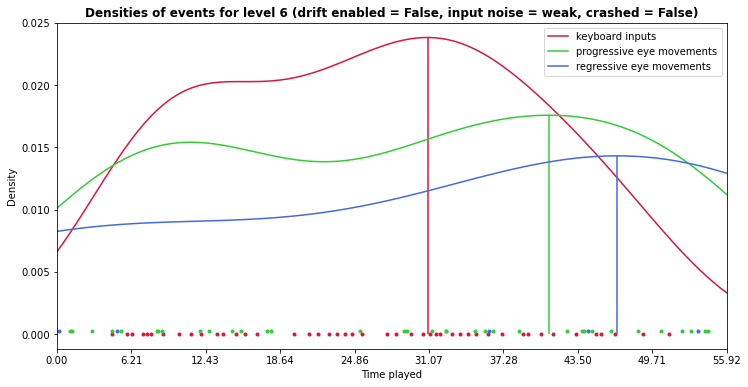

In [115]:
input_data = pre_process_input_data(pd.read_csv(f'experimental_data/AE07EM1/data/AE07EM1_output_6FW_done_37.csv', index_col=False))
eye_data = pre_process_eye_data(pd.read_csv(f'experimental_data/AE07EM1/eye_data/AE07EM1_eye_tracking_output_6FW_37.csv', index_col=False))

plot_kde_combined(input_data=input_data, eye_data=eye_data, safe_plot=False)

# Eyes fixating on ship

In [ ]:
code = "2FS_02"
only_ship_data = pd.read_csv(f'eye_data/only_ship_eye_tracking_output_{code}.csv', index_col=False)
only_ship_data = pre_process_eye_data(only_ship_data)

fixations = only_ship_data[only_ship_data["Fixation"] == 1.0]

fig, ax = plt.subplots(figsize=(12, 6))
ax.set_title(f"{code}", fontdict={"fontweight": "bold"})

# axis labels
ax.set_xlabel("observation space x")
ax.set_ylabel("observation space y")

ax.set_xlim([-120, 120])
ax.set_ylim([-600, 600])

#plt.gca().invert_yaxis()

# Plotting
colors = ["crimson", "limegreen"]

#ax.scatter(fixations.LeftEyeX, fixations.LeftEyeY, marker=".", color=colors[0], alpha=0.3)
#ax.scatter(fixations.RightEyeX, fixations.RightEyeY, marker=".", color=colors[1], alpha=0.3)

heatmap_left = sns.kdeplot(x=fixations.LeftEyeX, 
                           y=fixations.LeftEyeY, 
                           cmap="Reds",
                           shade=True,
                           alpha=0.9,
                           bw_adjust=0.4)

heatmap_right = sns.kdeplot(x=fixations.RightEyeX, 
                           y=fixations.RightEyeY, 
                           cmap="Greens",
                           shade=True,
                           alpha=0.9,
                           bw_adjust=0.4)

y_coord = point_estimate(fixations.converging_eye_y)[0]
ax.axhline(y_coord, color="lightskyblue")
x_coord = point_estimate(fixations.converging_eye_x)[0]
ax.axvline(x_coord, color="lightskyblue")

handles = [mpatches.Patch(facecolor=plt.cm.Reds(100), label="left eye"),
           mpatches.Patch(facecolor=plt.cm.Greens(100), label="right eye"),
           mpatches.Patch(facecolor=plt.cm.Blues(100), label="converging eyes")]
ax.legend(handles=handles)

In [ ]:
code = "3FW_01"
only_ship_data = pd.read_csv(f'eye_data/only_ship_eye_tracking_output_{code}.csv', index_col=False)
only_ship_data = pre_process_eye_data(only_ship_data)

fixations = only_ship_data[only_ship_data["Fixation"] == 1.0]

fig, ax = plt.subplots(figsize=(12, 6))
ax.set_title(f"{code}", fontdict={"fontweight": "bold"})

# axis labels
ax.set_xlabel("observation space x")
ax.set_ylabel("observation space y")

ax.set_xlim([-120, 120])
ax.set_ylim([-600, 600])

#plt.gca().invert_yaxis()

# Plotting
colors = ["crimson", "limegreen"]

#ax.scatter(fixations.LeftEyeX, fixations.LeftEyeY, marker=".", color=colors[0], alpha=0.3)
#ax.scatter(fixations.RightEyeX, fixations.RightEyeY, marker=".", color=colors[1], alpha=0.3)

heatmap_left = sns.kdeplot(x=fixations.LeftEyeX, 
                           y=fixations.LeftEyeY, 
                           cmap="Reds",
                           shade=True,
                           alpha=0.9,
                           bw_adjust=0.4)

heatmap_right = sns.kdeplot(x=fixations.RightEyeX, 
                           y=fixations.RightEyeY, 
                           cmap="Greens",
                           shade=True,
                           alpha=0.9,
                           bw_adjust=0.4)

y_coord = point_estimate(fixations.converging_eye_y)[0]
ax.axhline(y_coord, color="lightskyblue")
x_coord = point_estimate(fixations.converging_eye_x)[0]
ax.axvline(x_coord, color="lightskyblue")

handles = [mpatches.Patch(facecolor=plt.cm.Reds(100), label="left eye"),
           mpatches.Patch(facecolor=plt.cm.Greens(100), label="right eye"),
           mpatches.Patch(facecolor=plt.cm.Blues(100), label="converging eyes")]
ax.legend(handles=handles)

In [ ]:
code = "4FN_00"
only_ship_data = pd.read_csv(f'eye_data/only_ship_eye_tracking_output_{code}.csv', index_col=False)
only_ship_data = pre_process_eye_data(only_ship_data)

fixations = only_ship_data[only_ship_data["Fixation"] == 1.0]

fig, ax = plt.subplots(figsize=(12, 6))
ax.set_title(f"{code}", fontdict={"fontweight": "bold"})

# axis labels
ax.set_xlabel("observation space x")
ax.set_ylabel("observation space y")

ax.set_xlim([-120, 120])
ax.set_ylim([-600, 600])

#plt.gca().invert_yaxis()

# Plotting
colors = ["crimson", "limegreen"]

#ax.scatter(fixations.LeftEyeX, fixations.LeftEyeY, marker=".", color=colors[0], alpha=0.3)
#ax.scatter(fixations.RightEyeX, fixations.RightEyeY, marker=".", color=colors[1], alpha=0.3)

heatmap_left = sns.kdeplot(x=fixations.LeftEyeX, 
                           y=fixations.LeftEyeY, 
                           cmap="Reds",
                           shade=True,
                           alpha=0.9,
                           bw_adjust=0.4)

heatmap_right = sns.kdeplot(x=fixations.RightEyeX, 
                           y=fixations.RightEyeY, 
                           cmap="Greens",
                           shade=True,
                           alpha=0.9,
                           bw_adjust=0.4)

y_coord = point_estimate(fixations.converging_eye_y)[0]
ax.axhline(y_coord, color="lightskyblue")
x_coord = point_estimate(fixations.converging_eye_x)[0]
ax.axvline(x_coord, color="lightskyblue")

handles = [mpatches.Patch(facecolor=plt.cm.Reds(100), label="left eye"),
           mpatches.Patch(facecolor=plt.cm.Greens(100), label="right eye"),
           mpatches.Patch(facecolor=plt.cm.Blues(100), label="converging eyes")]
ax.legend(handles=handles)

# Finding runs that can be compared (same trial, same drift, different input_noise, but no crash)

In [ ]:
code="pilot4"

N_run = 43

levels = []
crashs = []
drifts = []
input_noise_magnitudes = []

for n_run in np.arange(N_run+1):
    input_data = pd.read_csv(f'input_data/{code}_output_{n_run:0>2}.csv', index_col=False)
    input_data = pre_process_input_data(input_data)
    levels.append(input_data.iloc[-1].trial)
    crashs.append(input_data.iloc[-1].collision)
    drifts.append(input_data.iloc[-1].drift_enabled)
    input_noise_magnitudes.append(input_data.iloc[-1].input_noise_magnitude)
    
trial_config = pd.DataFrame(columns=['level', 'crash', 'drift', 'input_noise'])
trial_config.level = levels
trial_config.crash = crashs
trial_config.drift = drifts
trial_config.input_noise = input_noise_magnitudes

trial_config

In [ ]:
trial_config_no_crashs = trial_config[trial_config.crash == False]

grouped = trial_config_no_crashs.groupby(["level", "drift"])
for name_of_the_group, group in grouped:
    print(name_of_the_group)
    print(group)

In [66]:
trial_config_combinations = [[13, 9, 24], [28, 26, 29], [21, 34, 12], [10, 16, 6], [25, 14, 39], [5, 33, 0], [40, 19, 11], [20, 1, 22], [42, 35, 18], [4, 43, 15], [3, 41, 37], [38, 31, 36]]
# 3rd trial in last entry is an unsuccessfull run for level 6, drift_enabled=True, input_noise=strong
len(trial_config_combinations)

12

In [ ]:
for combination in trial_config_combinations:
    print(combination)

# Eye resting position (differences in y dimension)

In [8]:
def plot_fixation_location_kde(eye_data_none, eye_data_weak, eye_data_strong, level=1, drift_enabled=False, scaling=18, edge=34, observation_space_x=40, observation_space_y=60, bottom_edge=15, exploring_fixations=False, safe_plot=False, path_to_save_folder=f"{os.getcwd()}/plots/kde_plots_fixation_locations/"):

    """
    :param eye_data_none: data of onput noise = none
    :param eye_data_weak: data of onput noise = weak
    :param eye_data_strong: data of onput noise = strong
    :param level: level played
    :param drift_enabled: True vs. False
    :param safe_plot: True vs. False - determines whether plots are saved or not
    :param path_to_save_folder: path to the folder in which plots are saved in case of safe_plot=True
    IMPORTANT: The function will not raise an error if the runs aren't of the same level and drift condition. It will only consider level and drift passed for labeling
    """
    
    if exploring_fixations:
        fixation_type = "exploring_fixations"
    else:
        fixation_type = "resting_fixations"
    
    # initiate plot 
    fig, axs = plt.subplots(1, 3, figsize=(12, 6))  # 3 subplots
    fig.suptitle(f"fixation locations KDE - {fixation_type}; level {level}, drift_enabled = {drift_enabled}")

    fig.supxlabel("observation space x")
    fig.supylabel("observation space y")

    # Plotting
    colors = ["crimson", "limegreen", "lightskyblue"]
    color_maps = ["Reds", "Greens", "Blues"]
    input_noise_magnitude = ["none", "weak", "strong"]
    counter = 0

    for eye_data, ax in zip([eye_data_none, eye_data_weak, eye_data_strong], axs.ravel()):

        # axis labels
        ax.set_xlabel(" ")
        ax.set_ylabel(" ")
        
        x_bounds = [edge*scaling, (edge+observation_space_x)*scaling]
        y_bounds = [0, (observation_space_y - bottom_edge)*scaling]

        ax.set_xlim([-300, 300])
        ax.set_ylim([-600, 600])
        
        # subset target fixations
        if exploring_fixations:
            target_fixations = eye_data[(eye_data["fixationOnset"] == 1.0) & (eye_data["exploring_fixation"] == 1)]
        else:
            target_fixations = eye_data[(eye_data["fixationOnset"] == 1.0) & (eye_data["exploring_fixation"] == 0)]

        
        # check for fixation within game boarders
        target_fixations = target_fixations[target_fixations["converging_eye_x_adjusted"].between(x_bounds[0], x_bounds[1])]

        heatmap = sns.kdeplot(x=target_fixations.converging_eye_x,
                              y=target_fixations.converging_eye_y,
                              cmap=color_maps[counter],
                              shade=True,
                              alpha=0.9,
                              bw_adjust=0.4,
                              ax=ax)
        
        if not exploring_fixations:
            y_coord = point_estimate(target_fixations.converging_eye_y)[0]
            ax.axhline(y_coord, color=colors[counter])
            x_coord = point_estimate(target_fixations.converging_eye_x)[0]
            ax.axvline(x_coord, color=colors[counter])

        counter += 1

    handles = [mpatches.Patch(facecolor=plt.cm.Reds(100), label=input_noise_magnitude[0]),
               mpatches.Patch(facecolor=plt.cm.Greens(100), label=input_noise_magnitude[1]),
               mpatches.Patch(facecolor=plt.cm.Blues(100), label=input_noise_magnitude[2])]
    fig.legend(handles=handles, loc='center right')
    
    if safe_plot:
        plt.savefig(f"{path_to_save_folder}fixation_location_kde_{fixation_type}_level_{level}_drift_enabled_{drift_enabled}", dpi=300)
        #plt.close()

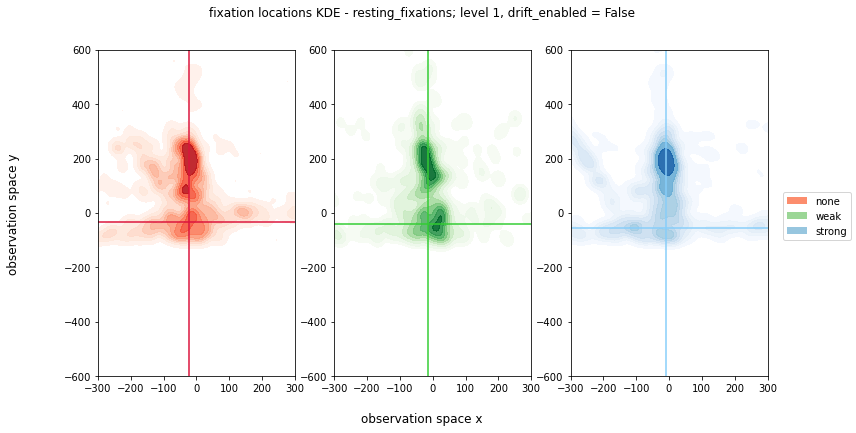

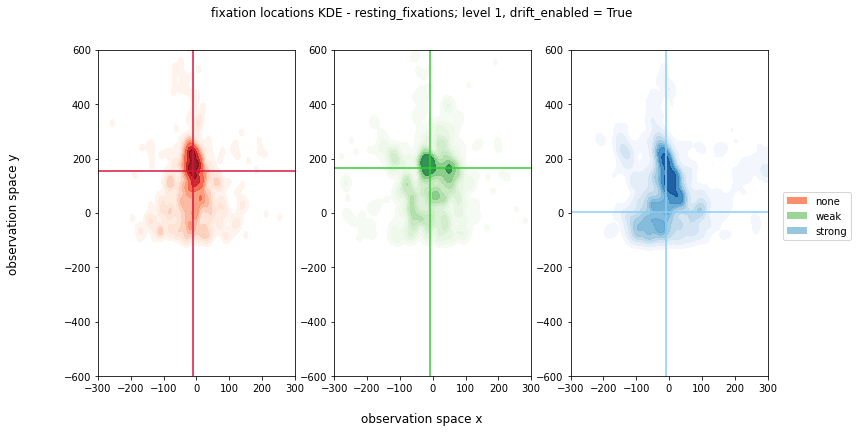

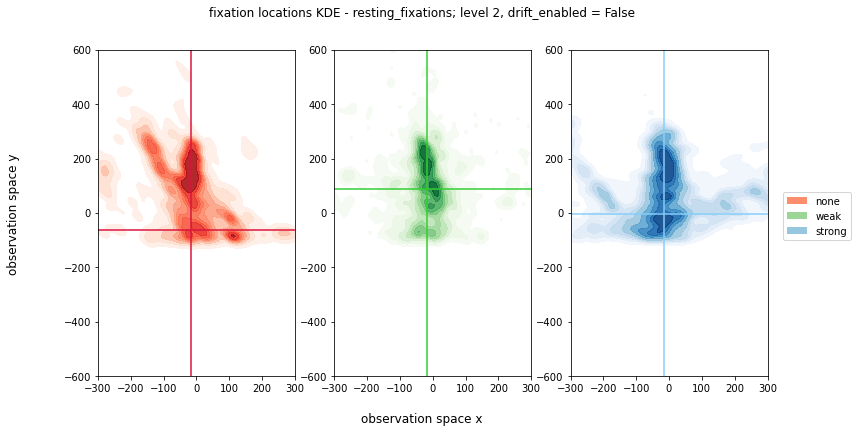

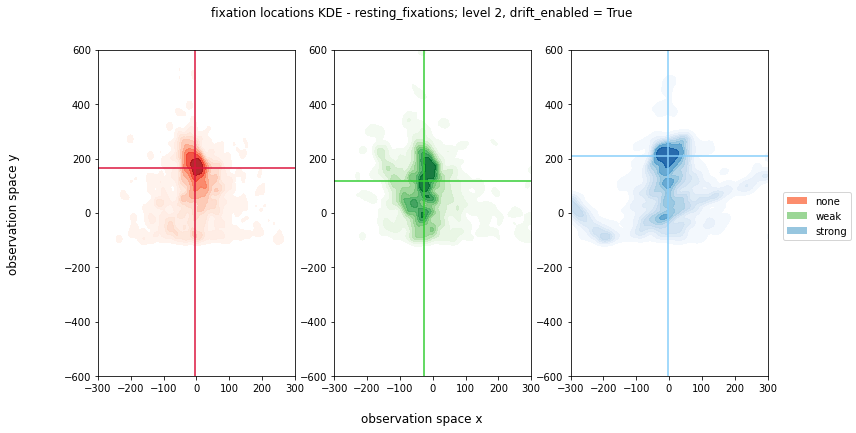

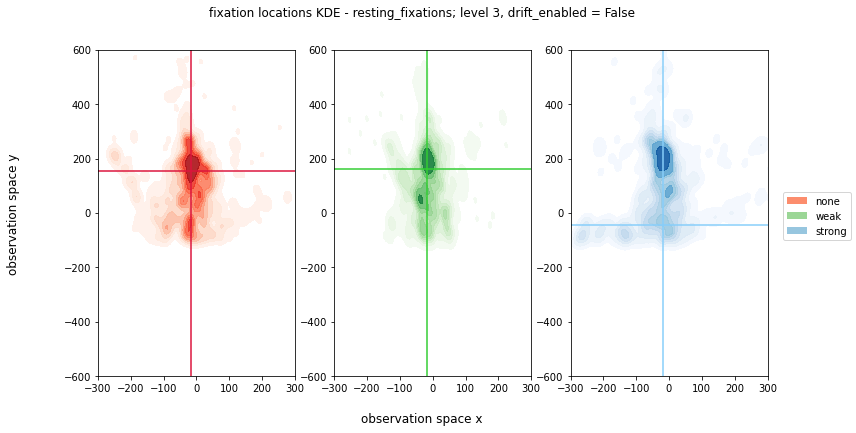

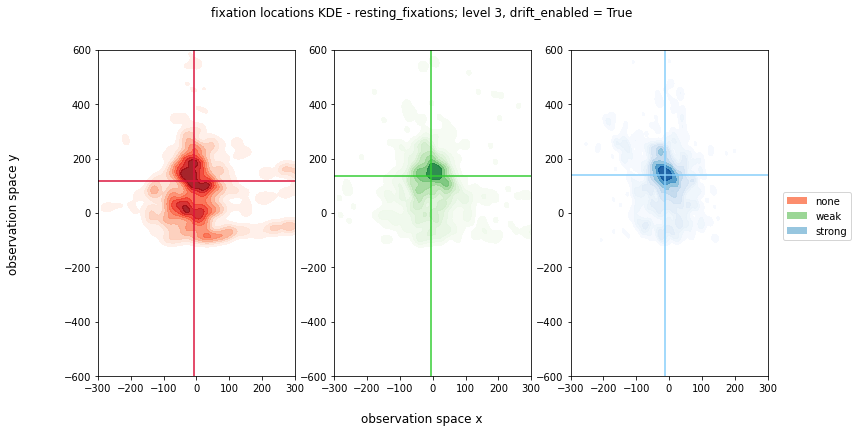

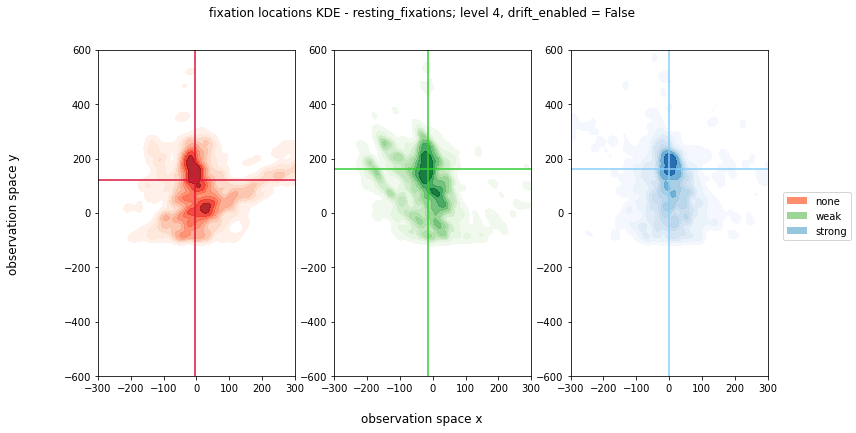

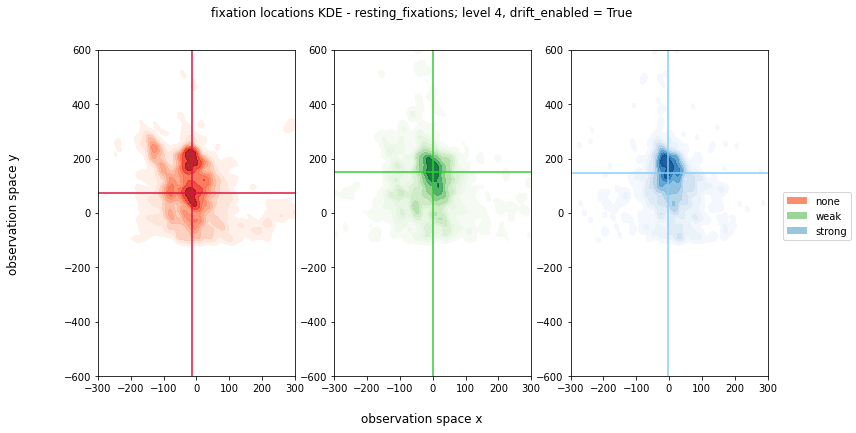

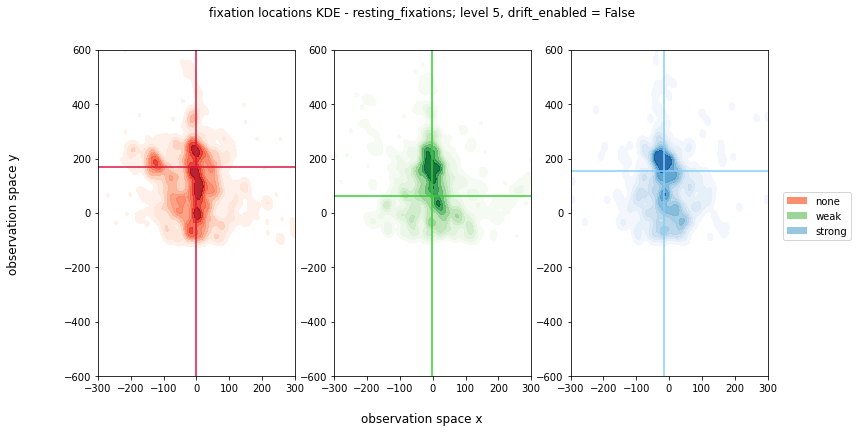

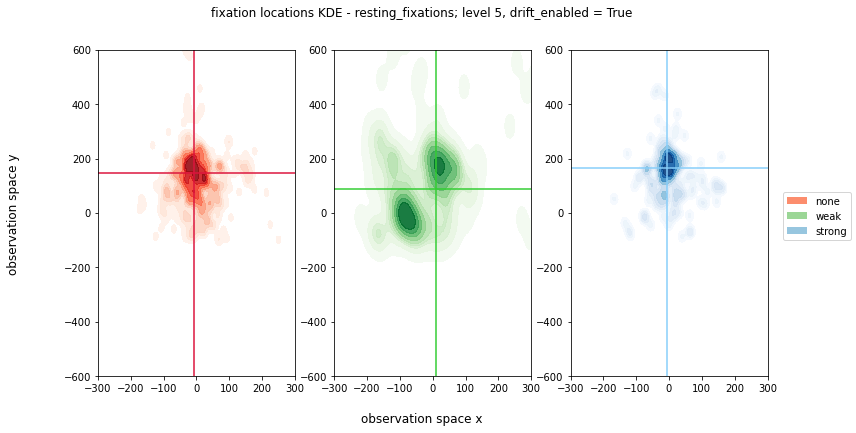

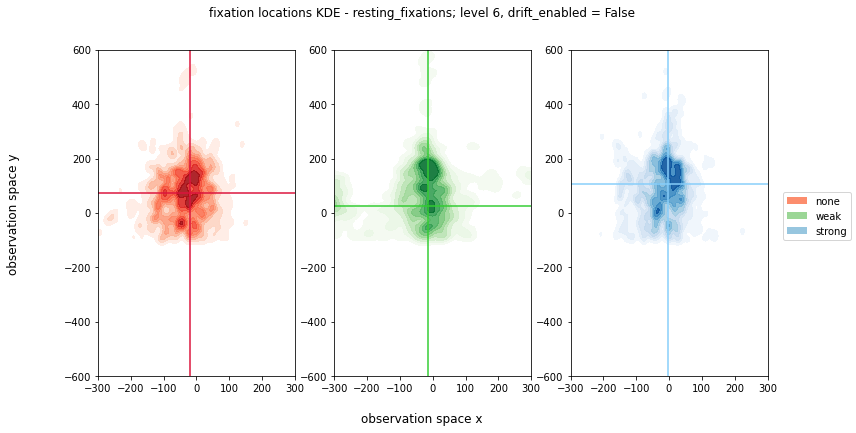

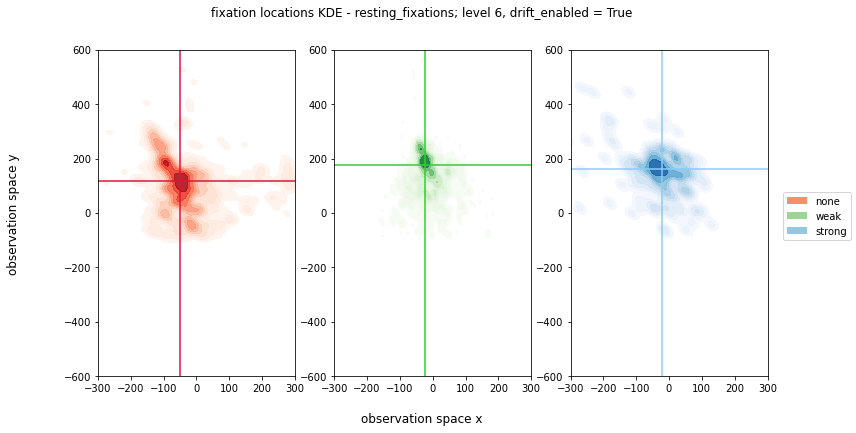

In [31]:
target_levels = [1, 2, 3, 4, 5, 6]
drift_enabled_args = [False, True]


args_list = [target_levels, drift_enabled_args]
arg_combs = list(itertools.product(*args_list))

for arg_comb in arg_combs:
    
    target_level = arg_comb[0]
    drift_enabled = arg_comb[1]

    eye_data = pd.read_csv(f'eye_data/experimental_eye_data_fixations.csv', index_col=False)
    eye_data_targetlevel = eye_data[(eye_data.level == target_level) & (eye_data.drift == str(f"{drift_enabled}")[0])]

    eye_data_none = eye_data_targetlevel[eye_data_targetlevel.input_noise == 'N']
    eye_data_weak = eye_data_targetlevel[eye_data_targetlevel.input_noise == 'W']
    eye_data_strong = eye_data_targetlevel[eye_data_targetlevel.input_noise == 'S']

    plot_fixation_location_kde(eye_data_none, eye_data_weak, eye_data_strong, target_level, drift_enabled, exploring_fixations=False, safe_plot=False)


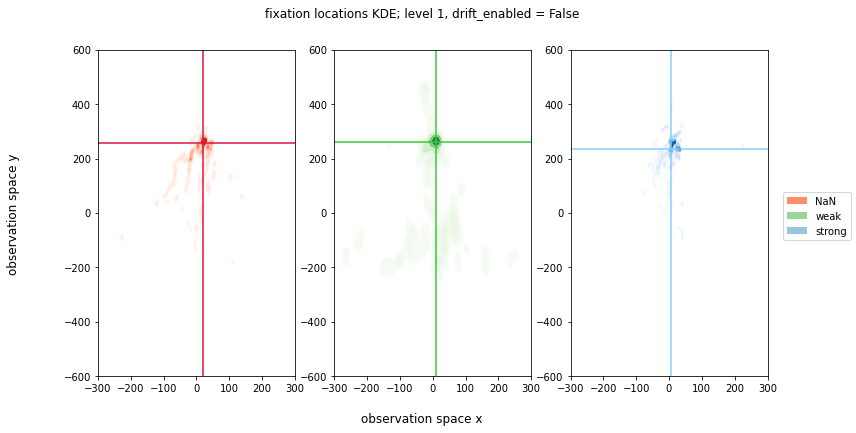

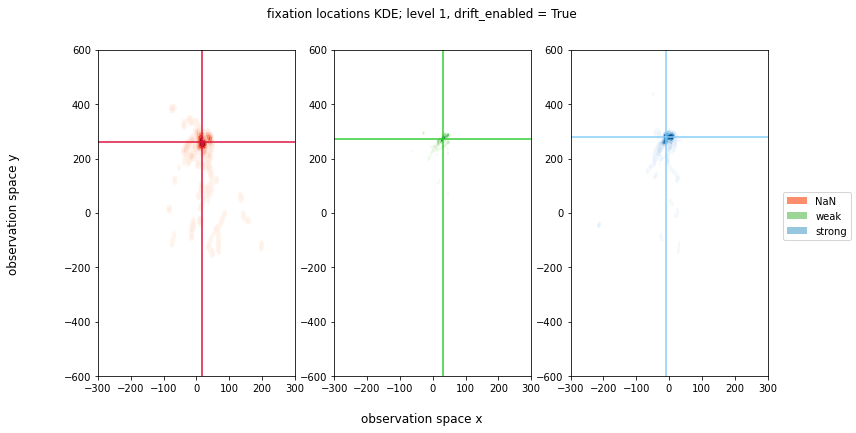

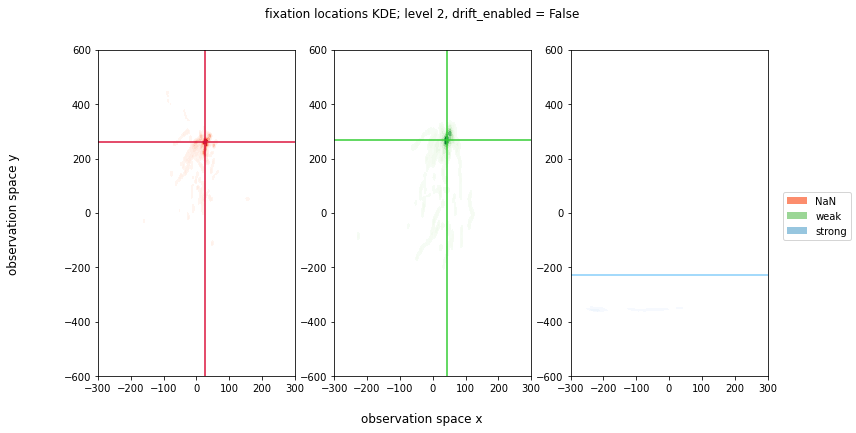

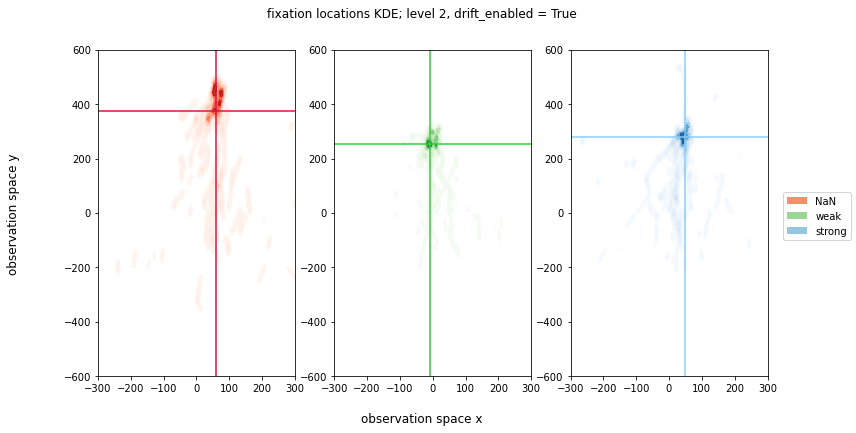

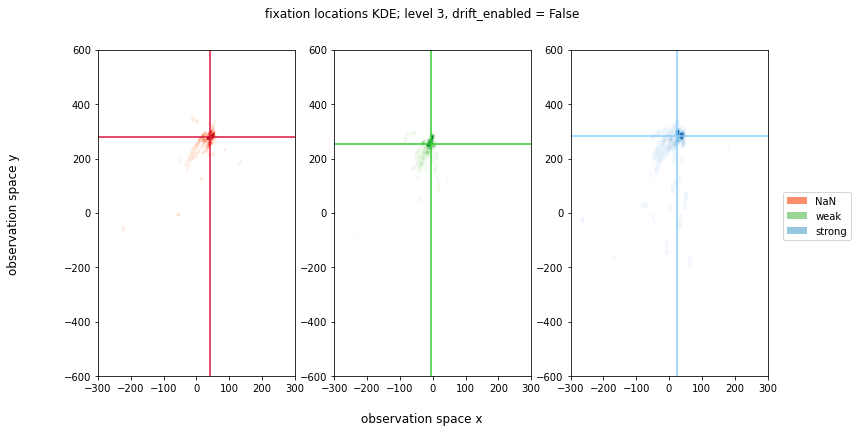

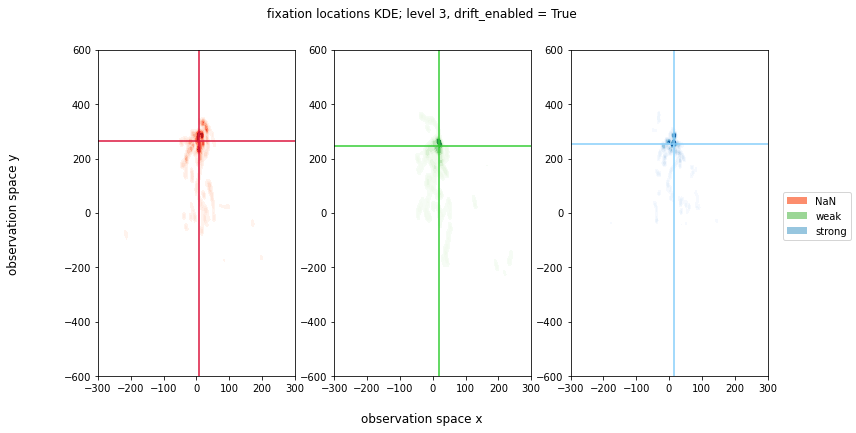

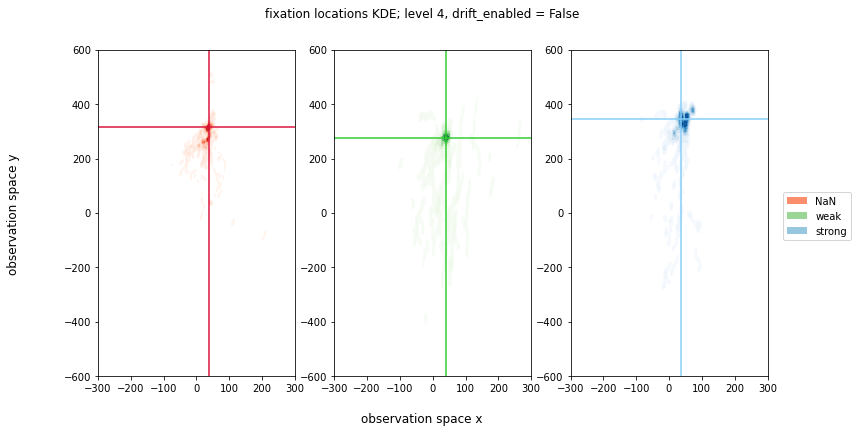

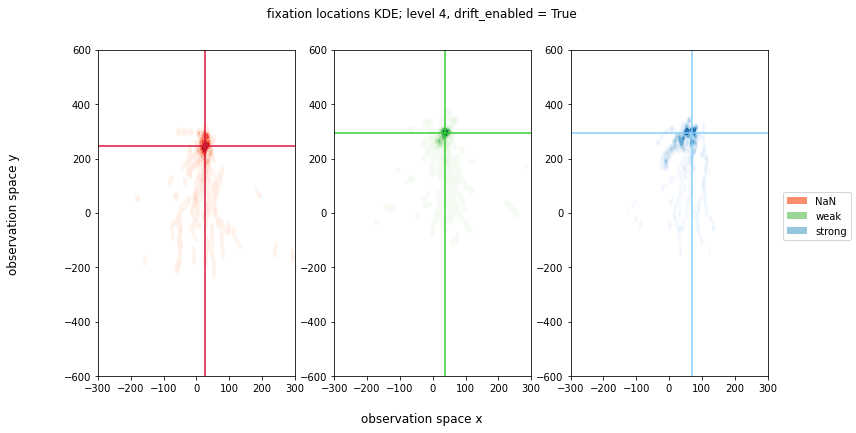

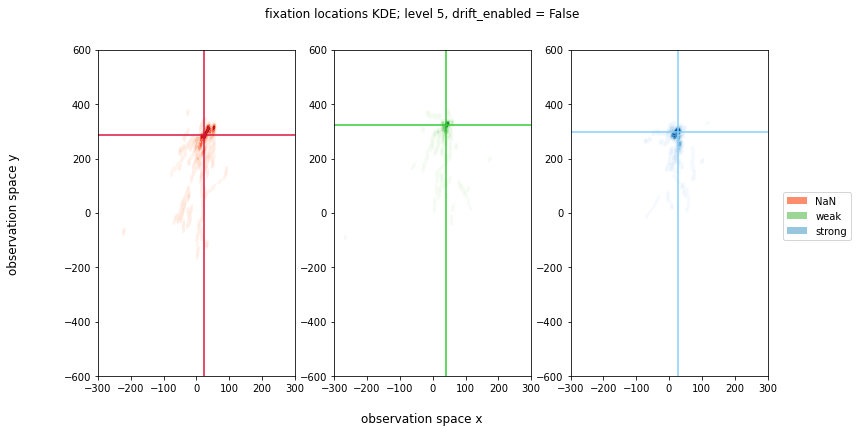

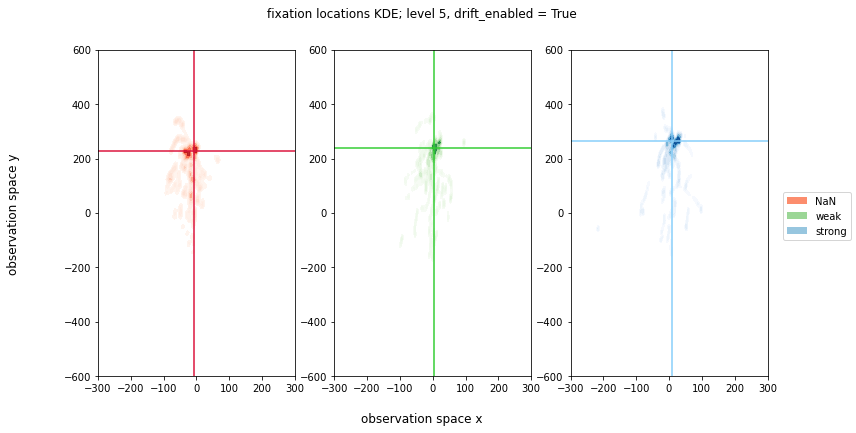

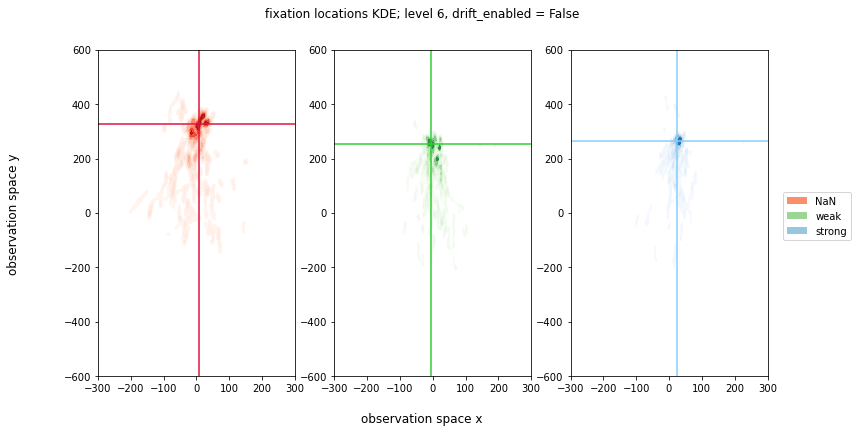

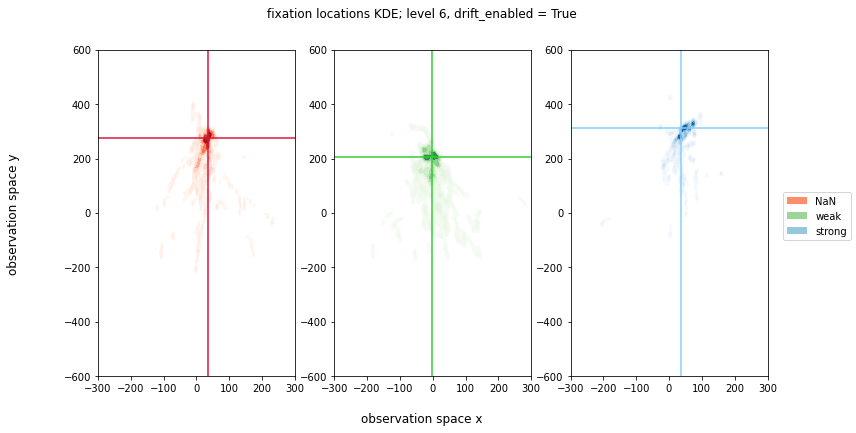

In [68]:
code = "pilot4"
for combination in trial_config_combinations:
    
    eye_data_none = pre_process_eye_data(pd.read_csv(f'eye_data/{code}_eye_tracking_output_{combination[0]:0>2}.csv', index_col=False))
    eye_data_weak = pre_process_eye_data(pd.read_csv(f'eye_data/{code}_eye_tracking_output_{combination[1]:0>2}.csv', index_col=False))
    eye_data_strong = pre_process_eye_data(pd.read_csv(f'eye_data/{code}_eye_tracking_output_{combination[2]:0>2}.csv', index_col=False))
    
    # get level features from exemplary input data
    input_data = pd.read_csv(f'input_data/{code}_output_{combination[0]:0>2}.csv', index_col=False)
    input_data = pre_process_input_data(input_data)
    level = input_data.iloc[-1].trial
    drift_enabled = input_data.iloc[-1].drift_enabled
    
    plot_fixation_location_kde(eye_data_none, eye_data_weak, eye_data_strong, level=level, drift_enabled=drift_enabled, safe_plot=False)

# Eye resting positions y (with drift onset if True)

In [9]:
def plot_eye_rest_y_over_time(eye_data_none, eye_data_weak, eye_data_strong, input_data, safe_plot=False, path_to_save_folder=f"{os.getcwd()}/plots/eye_resting_position_y/"):

    """
    :param eye_data_none: data of onput noise = none
    :param eye_data_weak: data of onput noise = weak
    :param eye_data_strong: data of onput noise = strong
    :param input_data: from which level features will be extracted as well as drift onset
    :param safe_plot: True vs. False - determines whether plots are saved or not
    :param path_to_save_folder: path to the folder in which plots are saved in case of safe_plot=True
    IMPORTANT: The function will not raise an error if the runs aren't of the same level and drift condition. It will only consider level and drift passed for labeling
    """
    
    # get level features from input data
    ## exemplary input data
    level = input_data.iloc[-1].trial
    drift_enabled = input_data.iloc[-1].drift_enabled
    
    fig, ax = plt.subplots(figsize=(12, 6))
    ax.set_title(f"eye resting y positions; level = {level}, drift_enabled = {drift_enabled}", fontdict={"fontweight": "bold"})

    # axis labels
    ax.set_xlabel("time_played")
    ax.set_ylabel("observation space y")
    
    ax.set_ylim([-200, 500])

    #plt.gca().invert_yaxis()

    # Plotting
    ## initiate colors and labels
    colors = ["coral", "lightgreen", "royalblue"]
    colors_p = ["crimson", "green", "blue"]
    color_maps = ["Reds", "Greens", "Blues"]
    input_noise_magnitude = ["none", "weak", "strong"]
    
    counter = 0
    
    if drift_enabled:
        # draw lines where drift tile onset
        drift_tile_onset = input_data[input_data.drift_tile_onset == 1]
        for drift_onset_time_tag in drift_tile_onset.time_played:
            ax.axvline(drift_onset_time_tag, color="pink")
            
        second_drift_onset = input_data[input_data.second_drift_tile_onset == 1]
        for drift_onset_time_tag in second_drift_onset.time_played:
            ax.axvline(drift_onset_time_tag, color="hotpink")
    
    #for run in list_of_runs:
    for eye_data in [eye_data_none, eye_data_weak, eye_data_strong]:
        
        fixations = eye_data[eye_data["Fixation"] == 1]

        # draw on canvas
        ax.plot(fixations.time_tag, fixations.converging_eye_y, color=colors[counter], alpha=0.8)
        
        counter += 1
    
    handles = [mpatches.Patch(facecolor=plt.cm.Reds(100), label=[input_noise_magnitude[0]]),
               mpatches.Patch(facecolor=plt.cm.Greens(100), label=[input_noise_magnitude[1]]),
               mpatches.Patch(facecolor=plt.cm.Blues(100), label=[input_noise_magnitude[2]])]
    ax.legend(handles=handles)
    
    if safe_plot:
        plt.savefig(f"{path_to_save_folder}eye_resting_position_y_level_{level}_drift_enabled_{drift_enabled}", dpi=300)
        #plt.close()

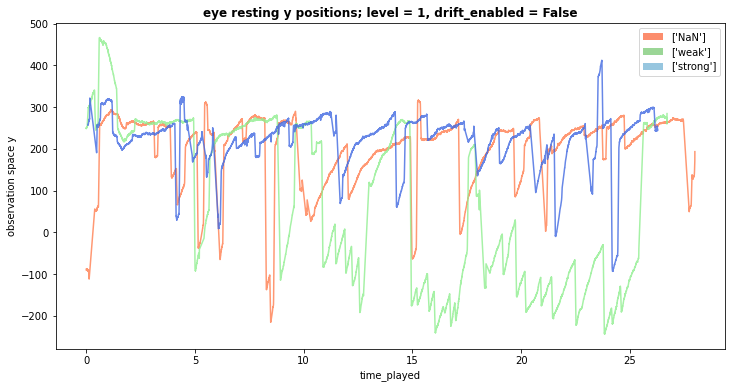

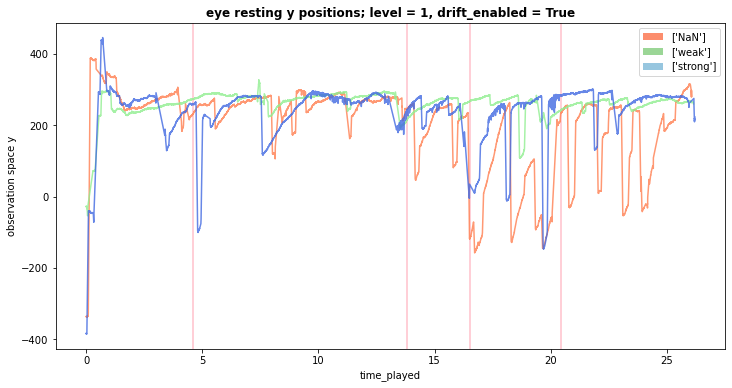

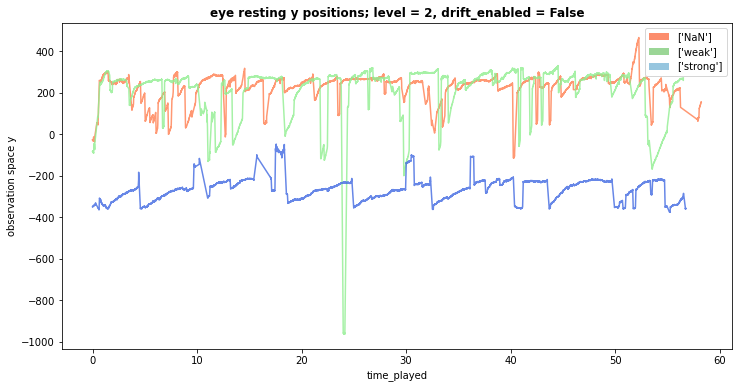

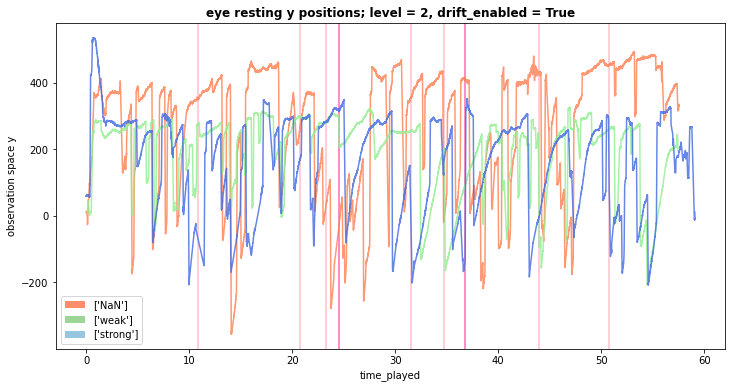

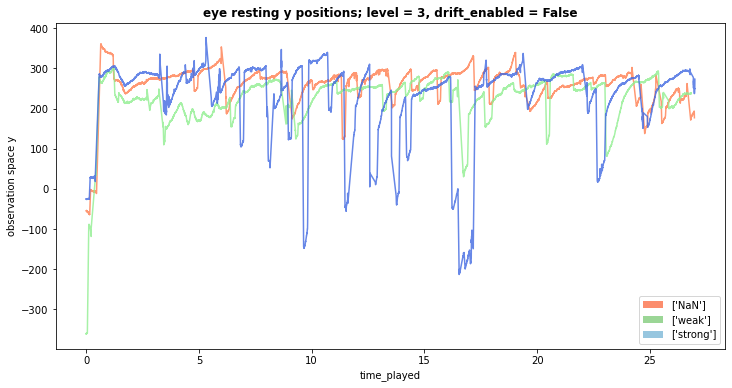

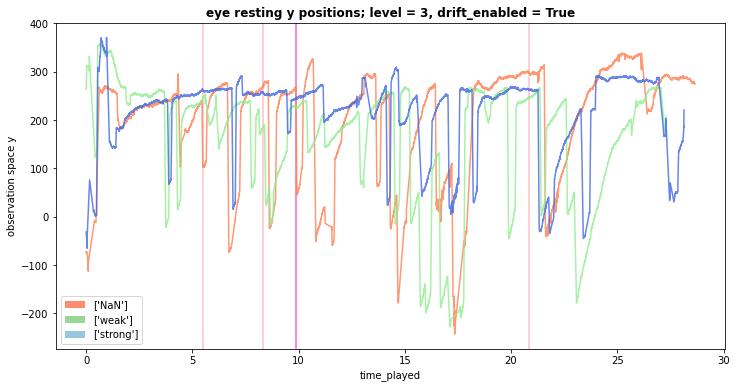

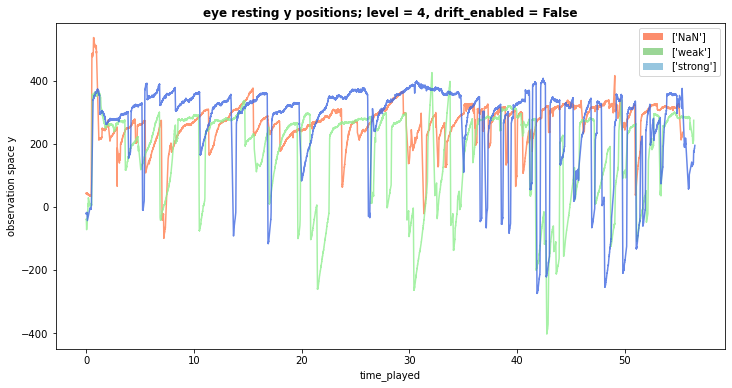

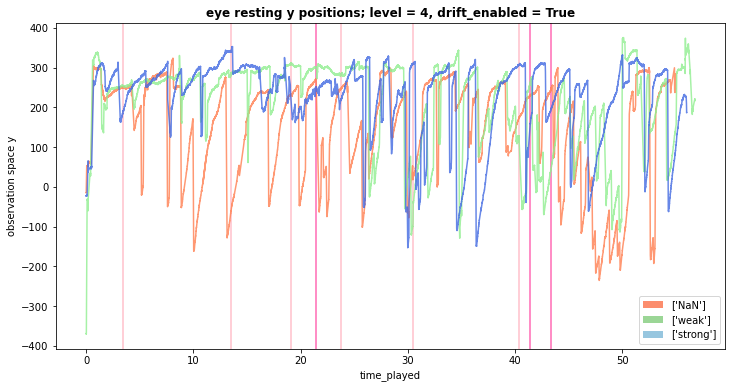

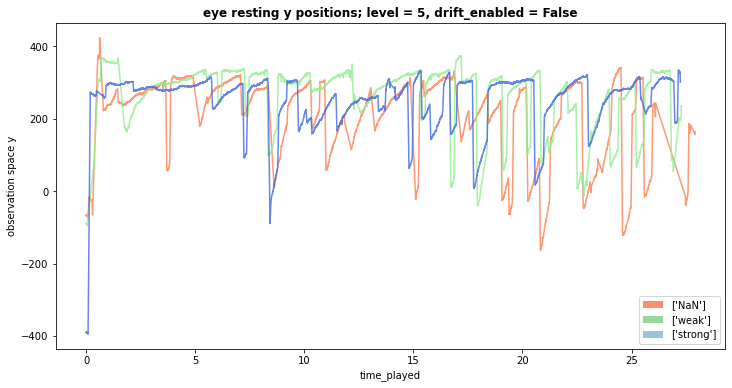

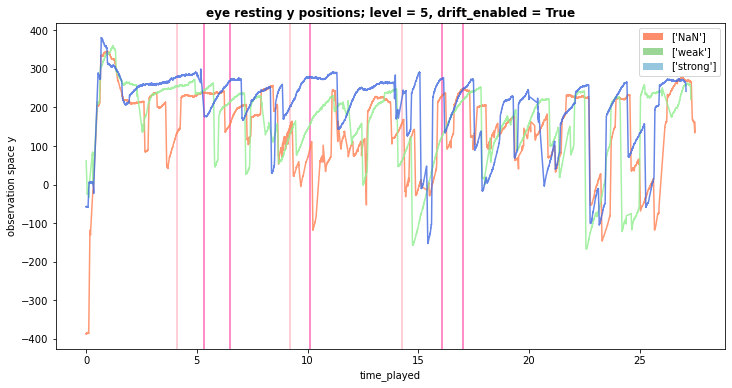

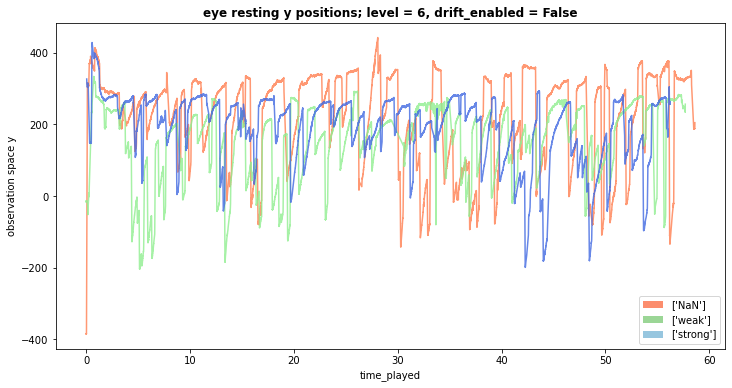

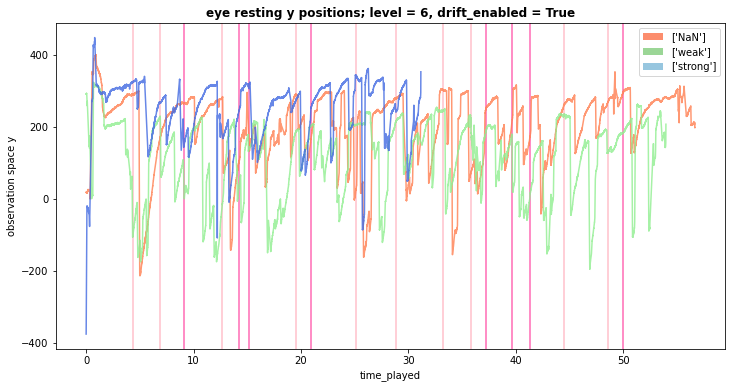

In [55]:
code = "pilot4"
for combination in trial_config_combinations:
    
    eye_data_none = pre_process_eye_data(pd.read_csv(f'eye_data/{code}_eye_tracking_output_{combination[0]:0>2}.csv', index_col=False))
    eye_data_weak = pre_process_eye_data(pd.read_csv(f'eye_data/{code}_eye_tracking_output_{combination[1]:0>2}.csv', index_col=False))
    eye_data_strong = pre_process_eye_data(pd.read_csv(f'eye_data/{code}_eye_tracking_output_{combination[2]:0>2}.csv', index_col=False))
    
    # get level features from exemplary input data
    input_data = pd.read_csv(f'input_data/{code}_output_{combination[0]:0>2}.csv', index_col=False)
    input_data = pre_process_input_data(input_data)
    plot_eye_rest_y_over_time(eye_data_none, eye_data_weak, eye_data_strong, input_data, safe_plot=False)

Use varying alphas to highlight a specific input noise condition. The ones that are not important plot with alpha=0.1 and the one of interest with alpha=1.0

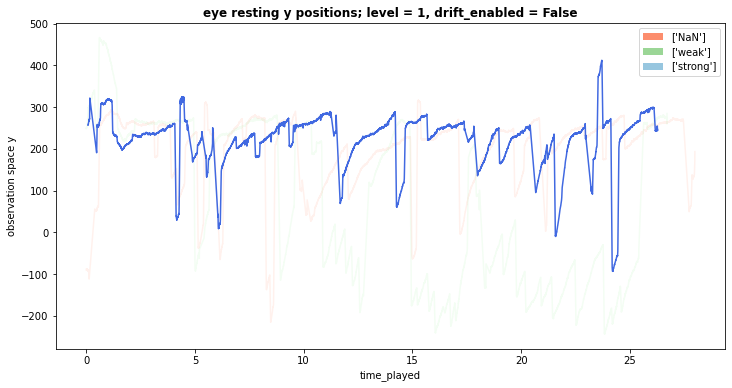

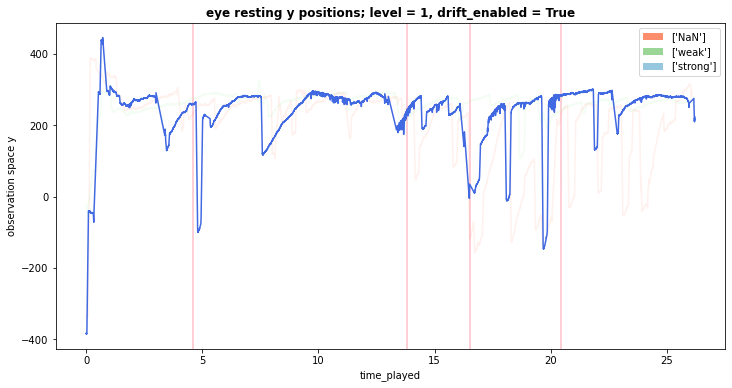

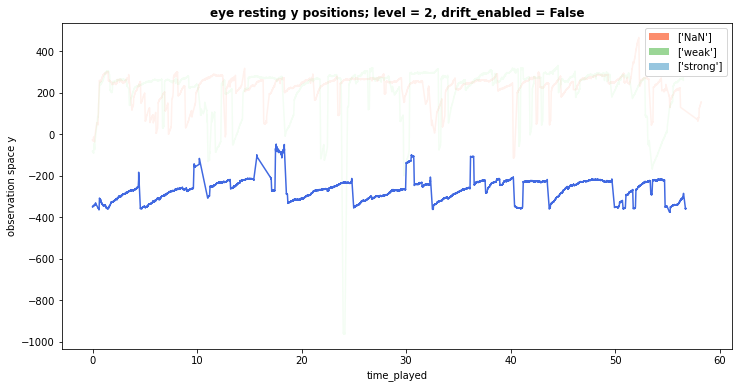

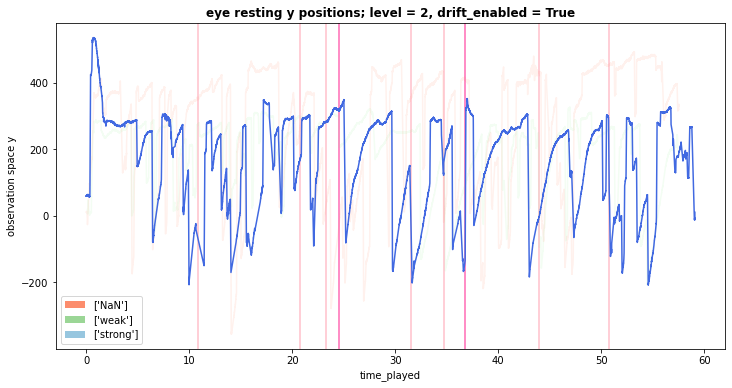

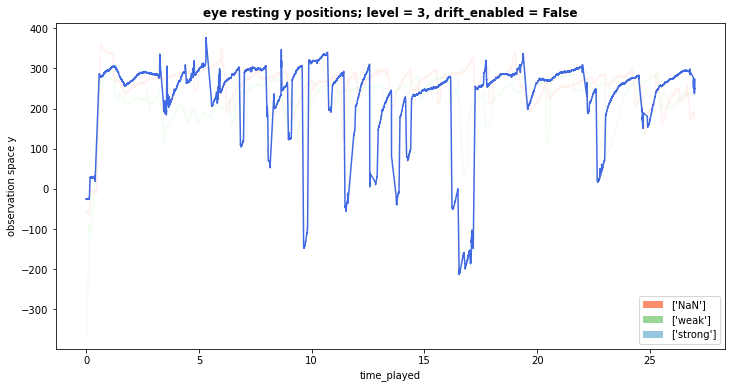

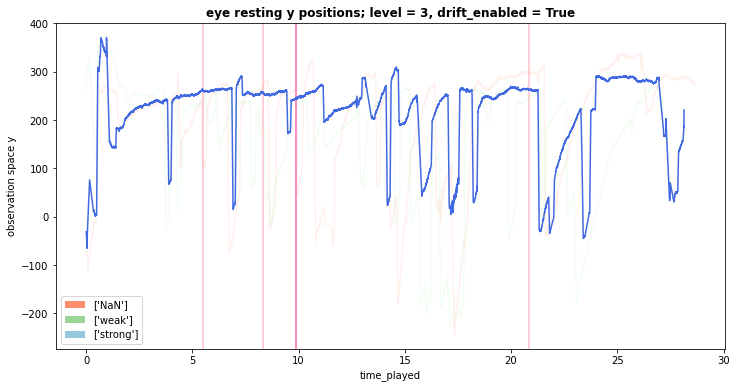

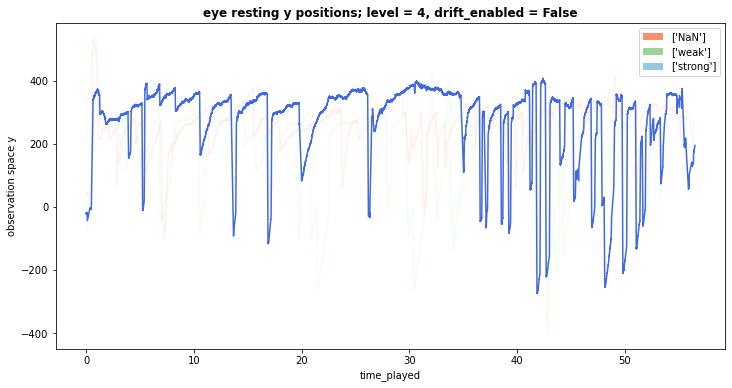

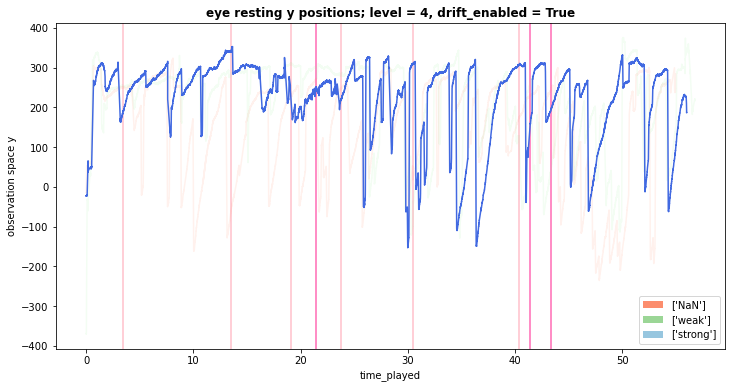

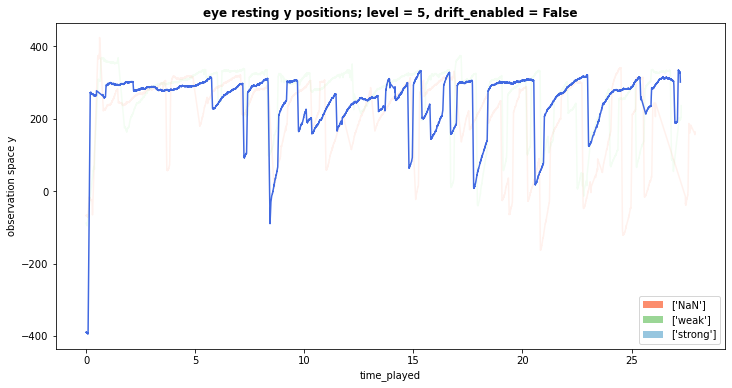

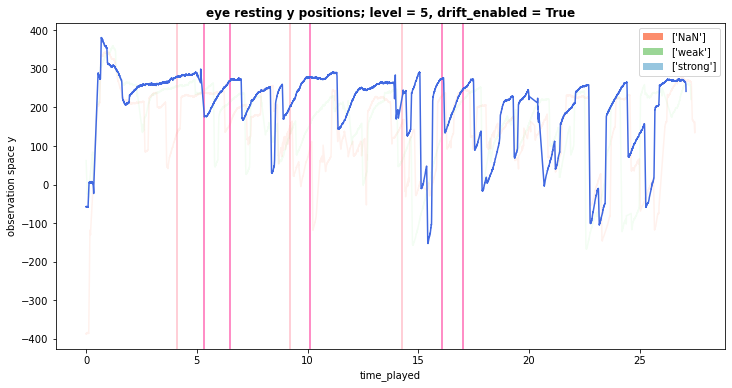

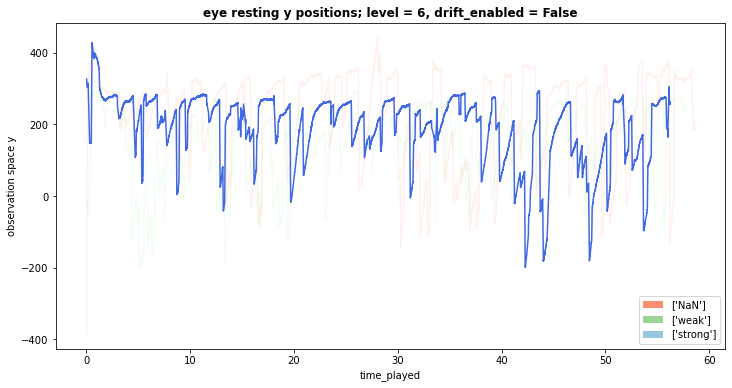

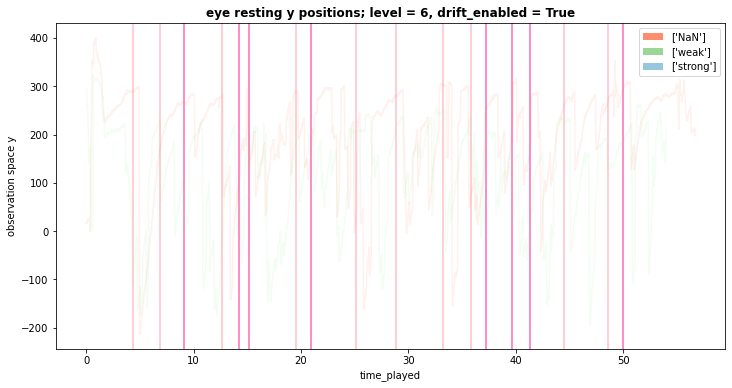

In [29]:
# high alpha for STRONG input noise

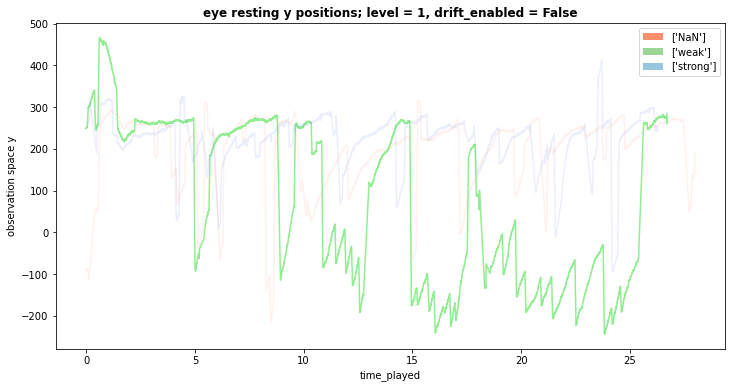

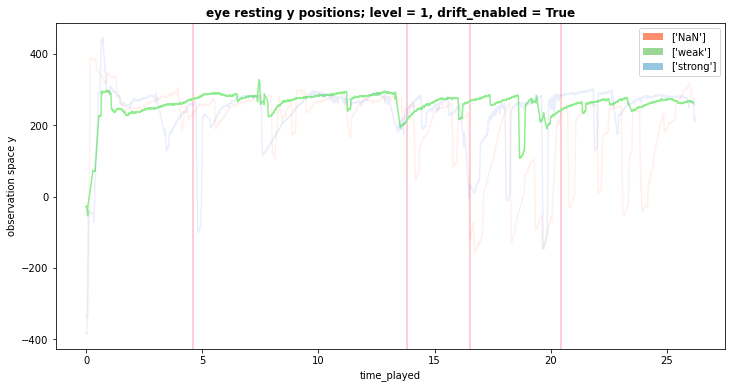

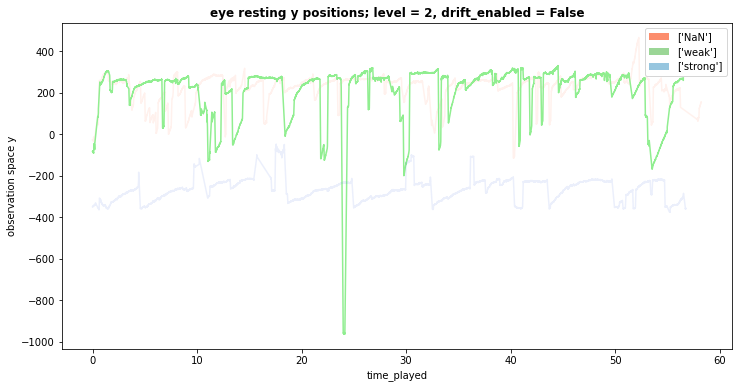

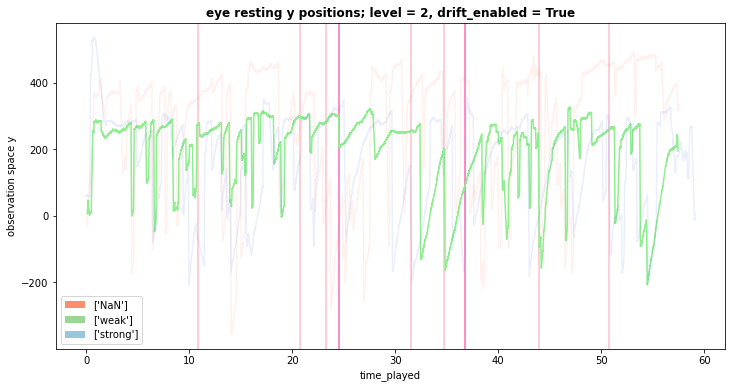

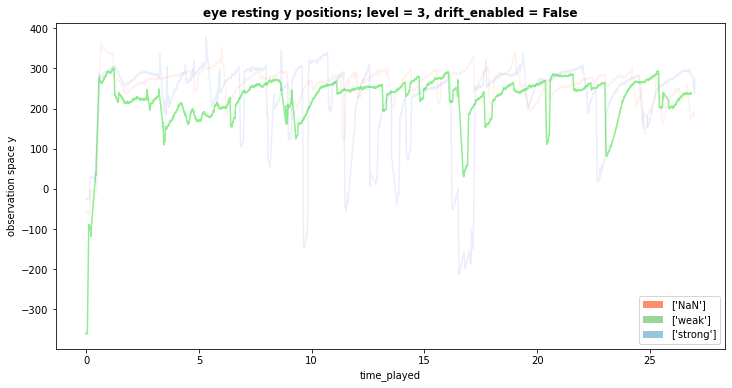

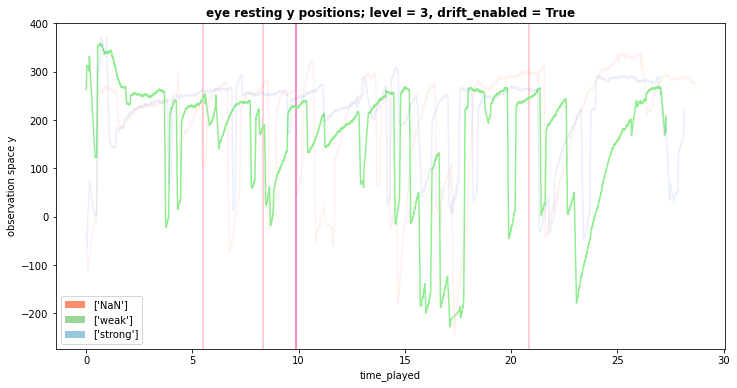

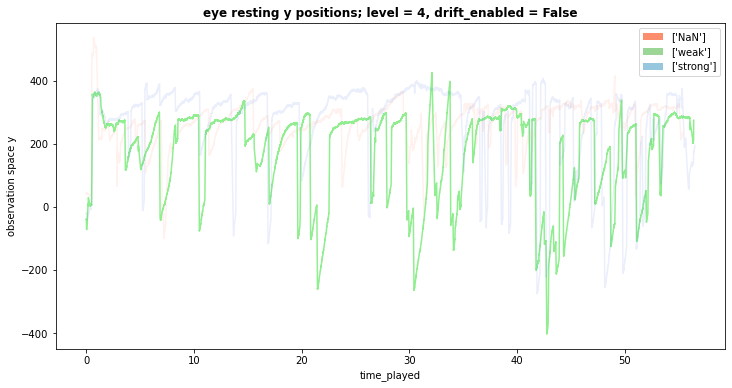

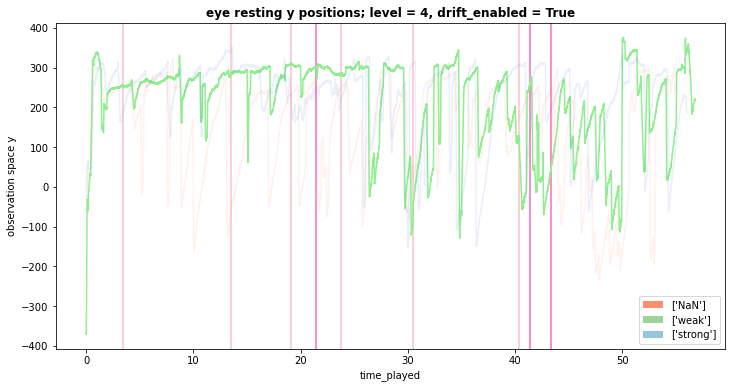

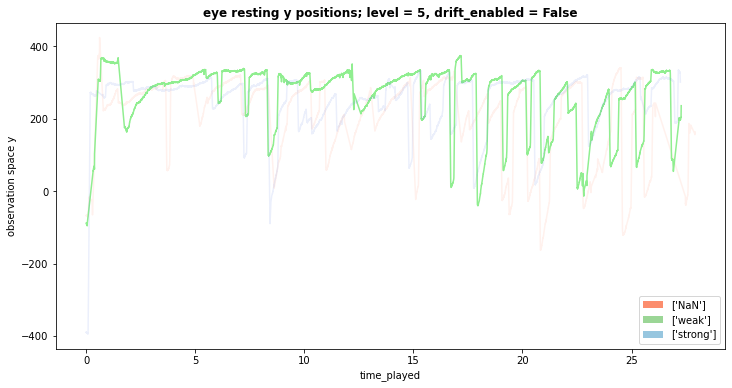

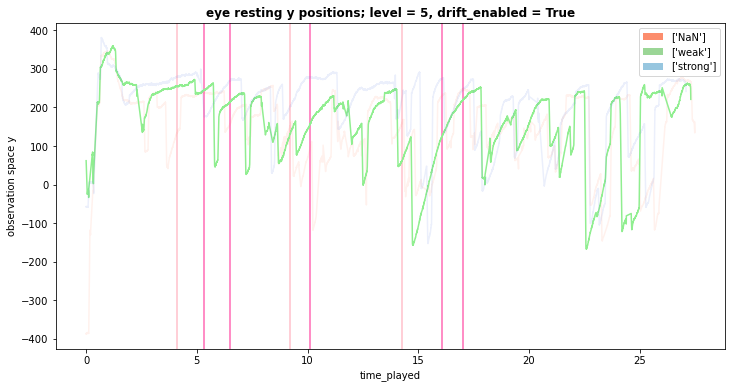

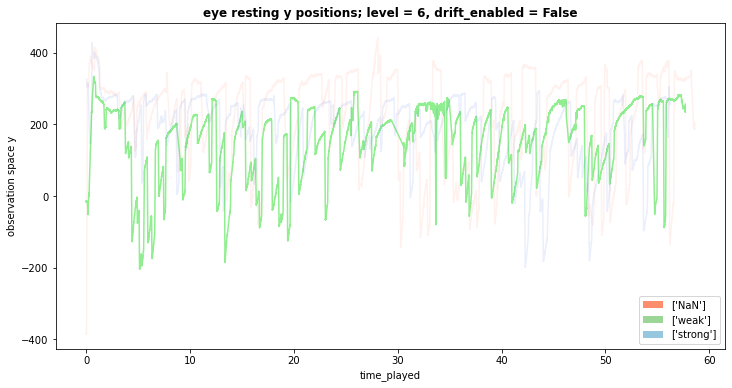

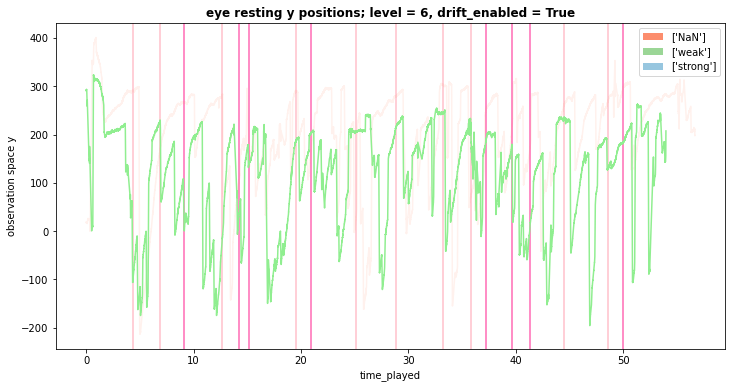

In [31]:
# high alpha for WEAK input noise

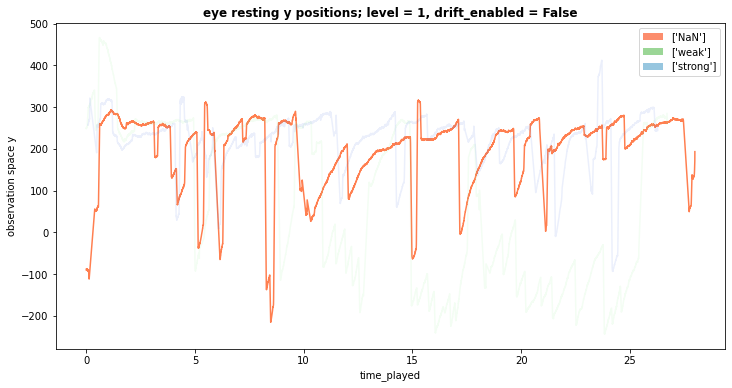

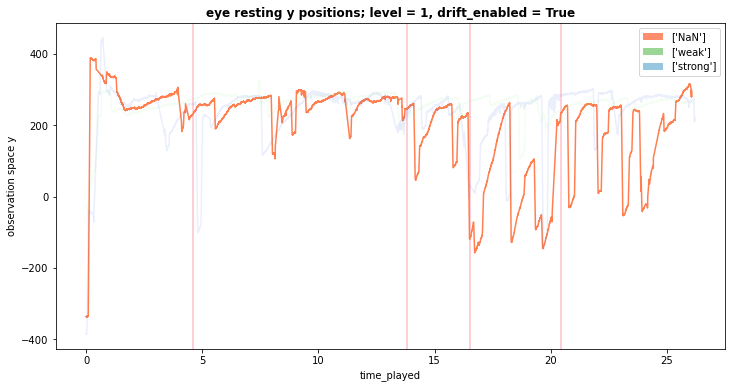

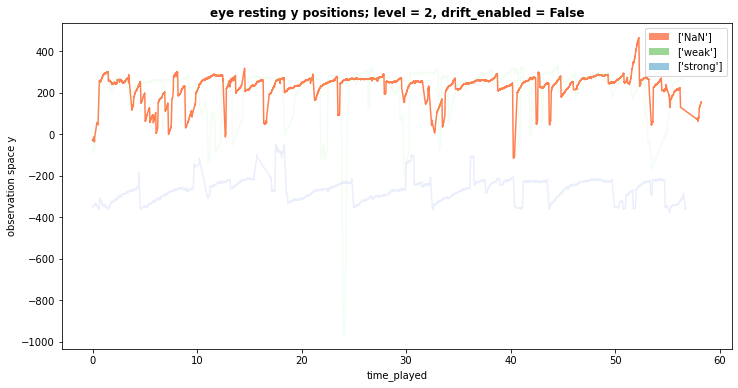

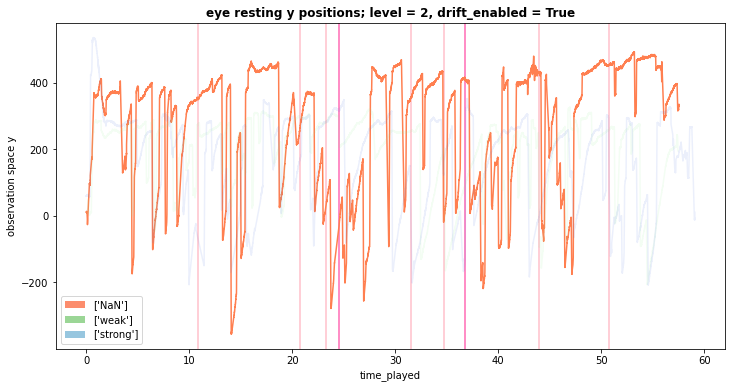

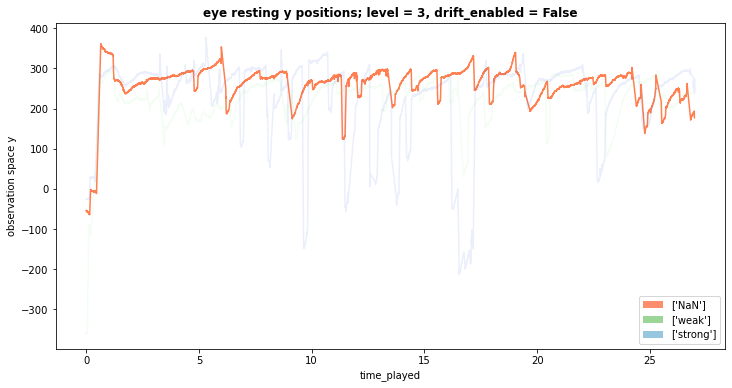

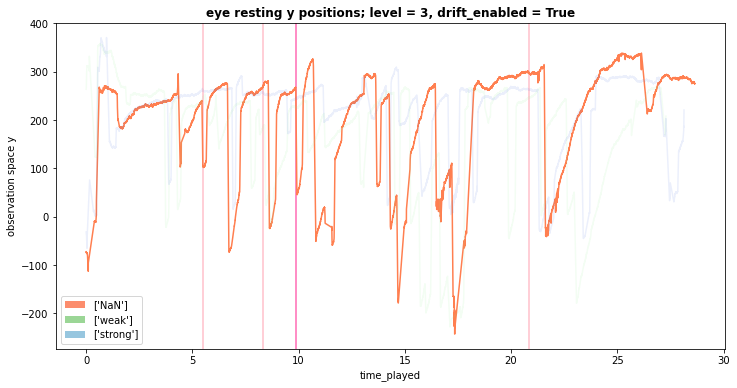

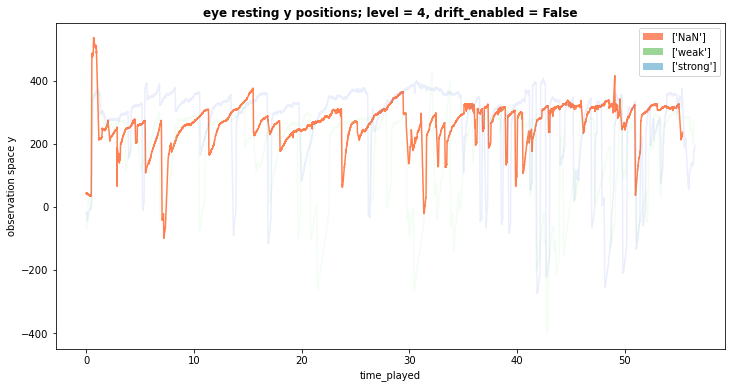

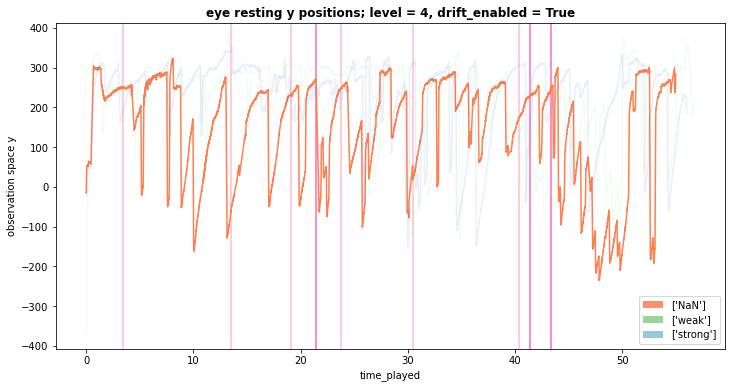

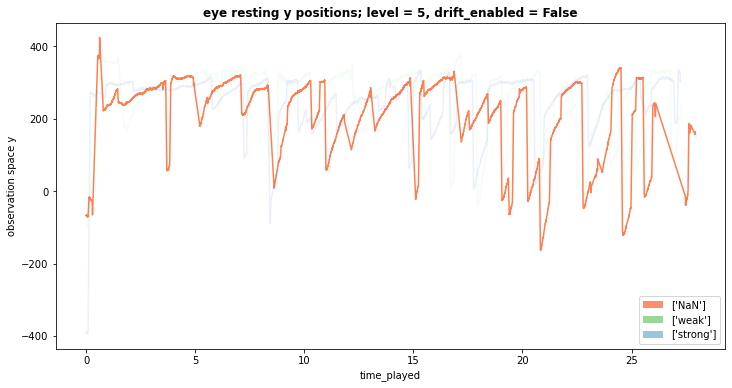

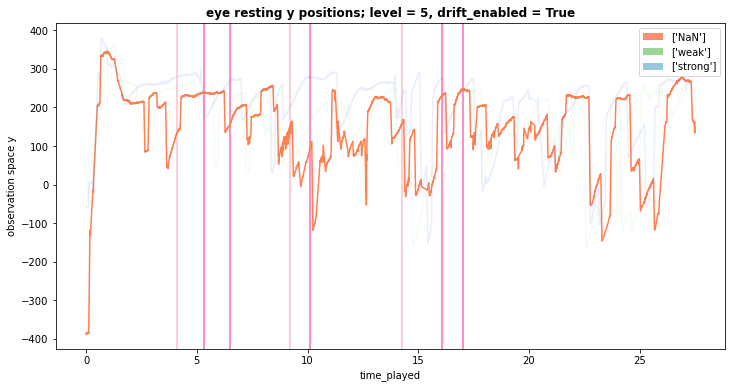

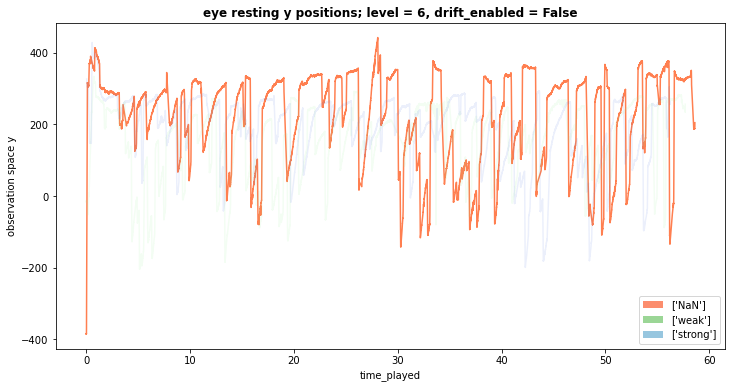

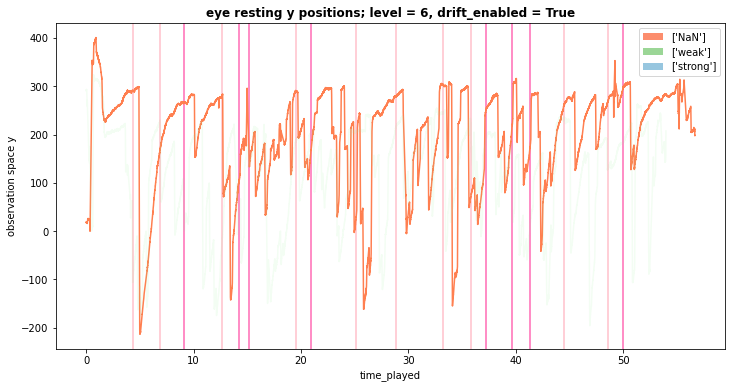

In [33]:
# high alpha for NAN input noise

# saccade amplitudes

In [10]:
def plot_saccade_amplitudes(eye_data_none, eye_data_weak, eye_data_strong, level, drift_enabled, regressive_saccades=False, safe_plot=False, path_to_save_folder=f"{os.getcwd()}/plots/plots_saccade_amplitude/"):    
    
    """
    :param eye_data_none: data of onput noise = none
    :param eye_data_weak: data of onput noise = weak
    :param eye_data_strong: data of onput noise = strong
    :param level: level played
    :param drift_enabled: True vs. False
    :param regressive_saccades: True vs. False; if True regressive saccades are targeted else progressive saccades
    :param safe_plot: True vs. False - determines whether plots are saved or not
    :param path_to_save_folder: path to the folder in which plots are saved in case of safe_plot=True
    IMPORTANT: The function will not raise an error if the runs aren't of the same level and drift condition. It will only consider level and drift passed for labeling
    """
    
    if regressive_saccades:
        saccade_type = "regressive_saccades"
    else:
        saccade_type = "progressive_saccades"
    
    fig, ax = plt.subplots(figsize=(12, 6))
    
    ax.set_title(f"saccade amplitudes - {saccade_type}; level {level}, drift_enabled = {drift_enabled}", fontdict={"fontweight": "bold"})

    # axis labels
    ax.set_xlabel("input noise magnitude")
    ax.set_ylabel("saccade amplitude (in °)")

    ax.set_xlim([-70, 70])
    ax.set_xticks([-50, 0, 50])
    ax.set_xticklabels(["NaN", "weak", "strong"])

    # Plotting
    colors = ["coral", "lightgreen", "royalblue"]
    colors_p = ["crimson", "green", "blue"]
    color_maps = ["Reds", "Greens", "Blues"]
    input_noise_magnitude = ["none", "weak", "strong"]
    offset = [-50, 0, 50]
    n_saccades = [np.nan, np.nan, np.nan]
    n_target_saccades = [np.nan, np.nan, np.nan]

    counter = 0

    for eye_data in [eye_data_none, eye_data_weak, eye_data_strong]:

        # all kinds of saccades
        # only consider the ones whichs amplitude is below 800 (arbitrarily chosen - saccades out of screen)
        saccades = eye_data[(eye_data["saccadeOnset"] >= 1) & (eye_data.saccade_amplitude < 800)]
        n_saccades[counter] = len(saccades)
        plot_labels = [offset[counter]]* len(saccades)
        saccades["plot_label"] = [offset[counter]]* len(saccades)
        # subset target saccades
        if regressive_saccades:
            target_saccades = saccades.loc[saccades["saccade_direction_y"] >= 0]
        else:
            target_saccades = saccades.loc[saccades["saccade_direction_y"] < 0]
        n_target_saccades[counter] = len(target_saccades)
        
        # draw on canvas
        ax.scatter(target_saccades.plot_label, target_saccades.saccade_amplitude, marker=".", color=colors_p[counter], alpha=0.3)
        
        fit_alpha, fit_loc, fit_beta = st.gamma.fit(target_saccades.saccade_amplitude)
        mean_gamma = fit_alpha*fit_beta
        ax.plot(offset[counter], mean_gamma, marker="_", markersize=15, color=colors_p[counter], alpha=1.0)
        # np.mean(target_saccades.saccade_amplitude)
        counter += 1

    handles = [mpatches.Patch(facecolor=plt.cm.Reds(100), label=[input_noise_magnitude[0], n_target_saccades[0], n_saccades[0]]),
               mpatches.Patch(facecolor=plt.cm.Greens(100), label=[input_noise_magnitude[1], n_target_saccades[1], n_saccades[1]]),
               mpatches.Patch(facecolor=plt.cm.Blues(100), label=[input_noise_magnitude[2], n_target_saccades[2], n_saccades[2]])]
    ax.legend(handles=handles)
    
    if safe_plot:
        plt.savefig(f"{path_to_save_folder}saccade_amplitude_{saccade_type}_level_{level}_drift_enabled_{drift_enabled}", dpi=300)
        #plt.close()

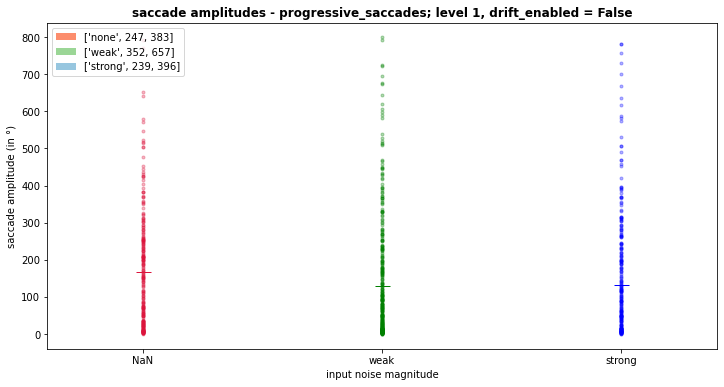

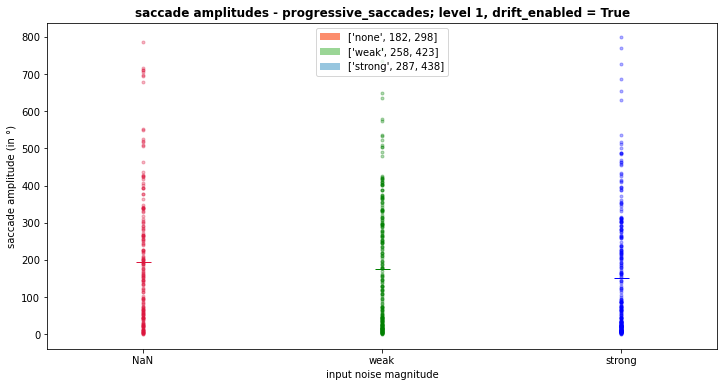

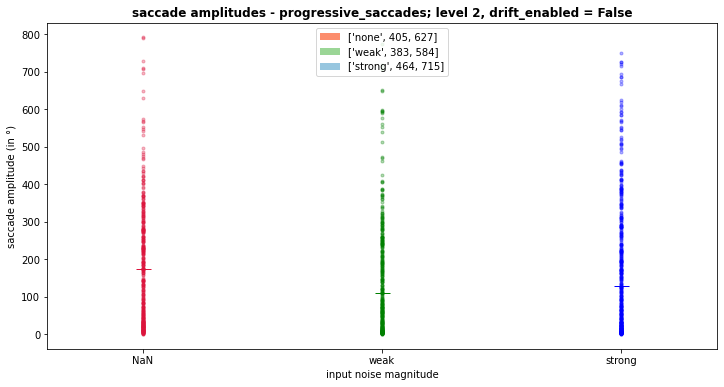

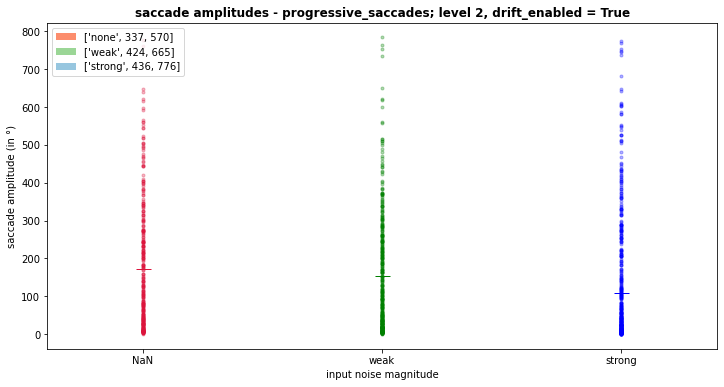

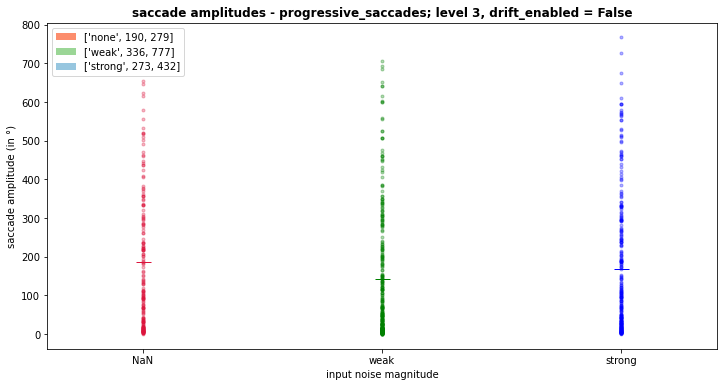

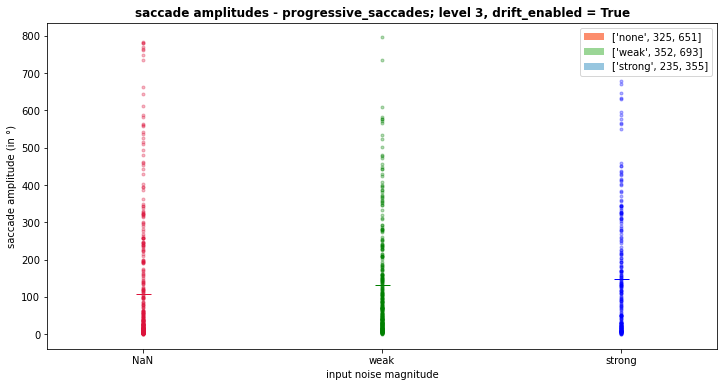

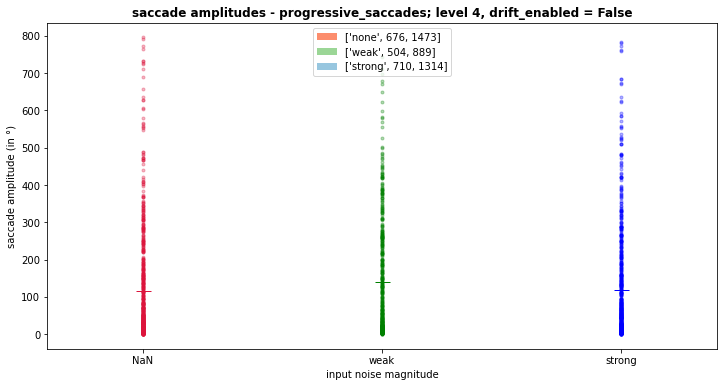

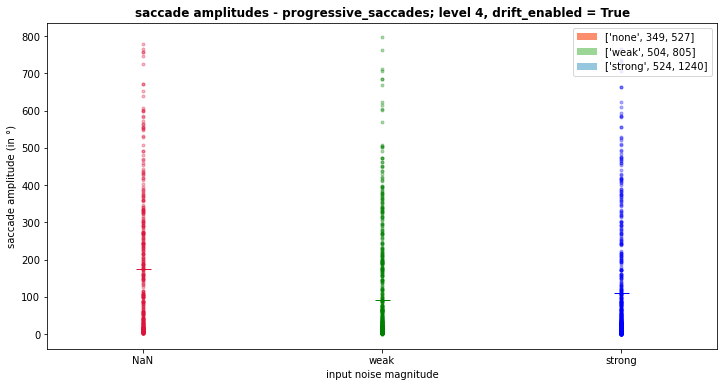

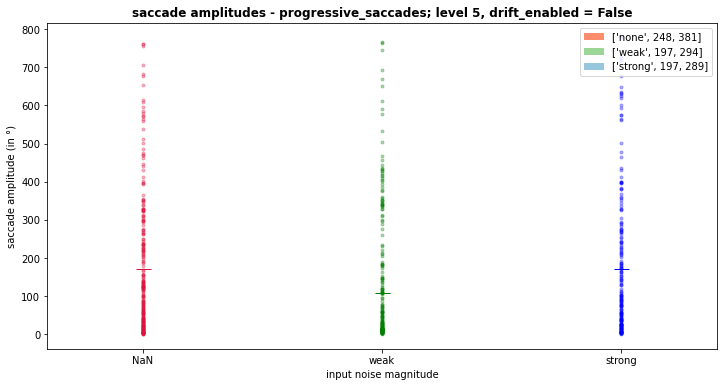

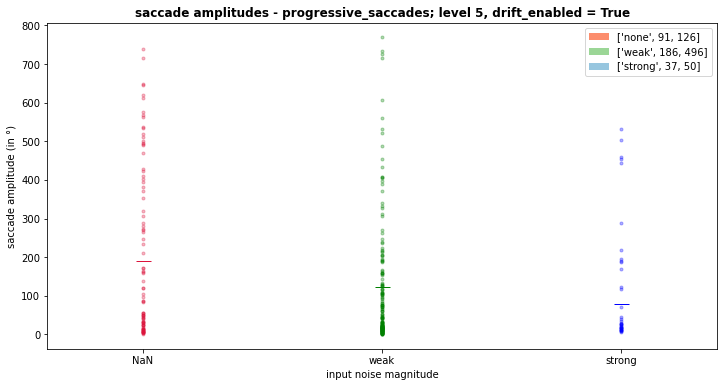

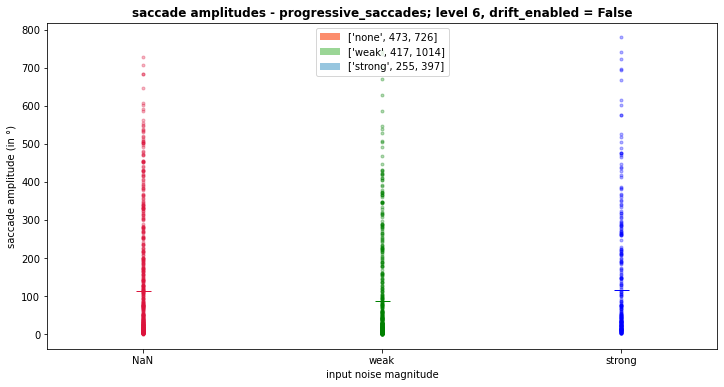

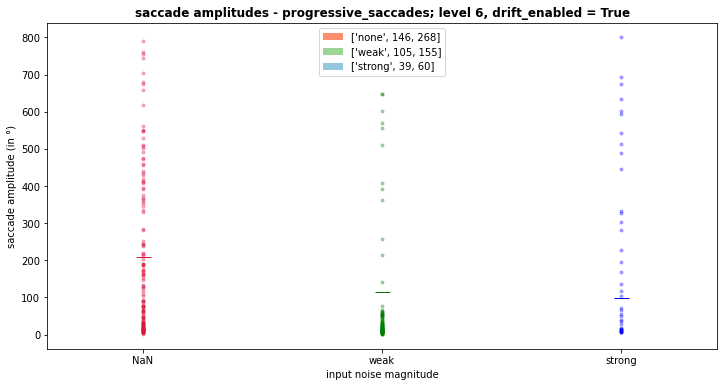

In [26]:
target_levels = [1, 2, 3, 4, 5, 6]
drift_enabled_args = [False, True]


args_list = [target_levels, drift_enabled_args]
arg_combs = list(itertools.product(*args_list))

for arg_comb in arg_combs:
    
    target_level = arg_comb[0]
    drift_enabled = arg_comb[1]

    eye_data = pd.read_csv(f'eye_data/experimental_eye_data_saccades.csv', index_col=False)
    eye_data_targetlevel = eye_data[(eye_data.level == target_level) & (eye_data.drift == str(f"{drift_enabled}")[0])]

    eye_data_none = eye_data_targetlevel[eye_data_targetlevel.input_noise == 'N']
    eye_data_weak = eye_data_targetlevel[eye_data_targetlevel.input_noise == 'W']
    eye_data_strong = eye_data_targetlevel[eye_data_targetlevel.input_noise == 'S']

    plot_saccade_amplitudes(eye_data_none, eye_data_weak, eye_data_strong, target_level, drift_enabled, regressive_saccades=False, safe_plot=False)


# Exploring saccade launch and landing sites

In [11]:
def plot_saccade_vectors(eye_data_none, eye_data_weak, eye_data_strong, level, drift_enabled, regressive_saccades=False, safe_plot=False, path_to_save_folder=f"{os.getcwd()}/plots/plots_saccade_vectors/"):
    
    """
    :param eye_data_none: data of onput noise = none
    :param eye_data_weak: data of onput noise = weak
    :param eye_data_strong: data of onput noise = strong
    :param level: level played
    :param drift_enabled: True vs. False
    :param regressive_saccades: True vs. False; if True regressive saccades are targeted else progressive saccades
    :param safe_plot: True vs. False - determines whether plots are saved or not
    :param path_to_save_folder: path to the folder in which plots are saved in case of safe_plot=True
    IMPORTANT: The function will not raise an error if the runs aren't of the same level and drift condition. It will only consider level and drift passed for labeling
    """
    
    if regressive_saccades:
        saccade_type = "regressive_saccades"
    else:
        saccade_type = "progressive_saccades"
    
    fig, axs = plt.subplots(1, 3, figsize=(12, 6))  # 3 subplots
    fig.suptitle(f"saccade vectors - {saccade_type}; level {level}, drift_enabled = {drift_enabled}")
    
    fig.supxlabel("observation space x")
    fig.supylabel("observation space y")   

    # Plotting
    colors = ["coral", "lightgreen", "royalblue"]
    colors_p = ["crimson", "green", "blue"]
    color_maps = ["Reds", "Greens", "Blues"]
    input_noise_magnitude = ["none", "weak", "strong"]
    n_saccades = [np.nan, np.nan, np.nan]
    n_target_saccades = [np.nan, np.nan, np.nan]

    counter = 0
    
    for eye_data, ax in zip([eye_data_none, eye_data_weak, eye_data_strong], axs.ravel()):
        
        # axis labels
        ax.set_xlabel(" ")
        ax.set_ylabel(" ")

        ax.set_xlim([-1000, 1000])
        ax.set_ylim([-600, 600])

        # all kinds of saccades
        saccades = eye_data[eye_data["saccadeOnset"] >= 1]
        n_saccades[counter] = len(saccades)

        # subset target saccades
        if regressive_saccades:
            target_saccades = saccades.loc[saccades["saccade_direction_y"] >= 0]
        else:
            target_saccades = saccades.loc[saccades["saccade_direction_y"] < 0]

        n_target_saccades[counter] = len(target_saccades)
        
        # loop through saccades
        for saccade in np.arange(len(target_saccades)):
            saccade_launch_site = [target_saccades.iloc[saccade].converging_eye_x, target_saccades.iloc[saccade].converging_eye_y]
            saccade_landing_site = [target_saccades.iloc[saccade].converging_eye_x + target_saccades.iloc[saccade].saccade_direction_x, target_saccades.iloc[saccade].converging_eye_y + target_saccades.iloc[saccade].saccade_direction_y]
            
            x_pos = [saccade_launch_site[0], saccade_landing_site[0]]
            y_pos = [saccade_launch_site[1], saccade_landing_site[1]]
            
            # draw on canvas
            ax.quiver(x_pos, y_pos, target_saccades.iloc[saccade].saccade_direction_x, target_saccades.iloc[saccade].saccade_direction_y, scale_units='xy', angles='xy', scale=1, color=colors[counter], alpha=1.0)

        counter += 1

    handles = [mpatches.Patch(facecolor=plt.cm.Reds(100), label=[input_noise_magnitude[0], n_target_saccades[0], n_saccades[0]]),
               mpatches.Patch(facecolor=plt.cm.Greens(100), label=[input_noise_magnitude[1], n_target_saccades[1], n_saccades[1]]),
               mpatches.Patch(facecolor=plt.cm.Blues(100), label=[input_noise_magnitude[2], n_target_saccades[2], n_saccades[2]])]
    fig.legend(handles=handles, loc='upper right', bbox_to_anchor=(0.98, 0.9), framealpha=1.0)
    
    if safe_plot:
        plt.savefig(f"{path_to_save_folder}saccade_vectors_{saccade_type}_level_{level}_drift_enabled_{drift_enabled}", dpi=300)
        #plt.close()

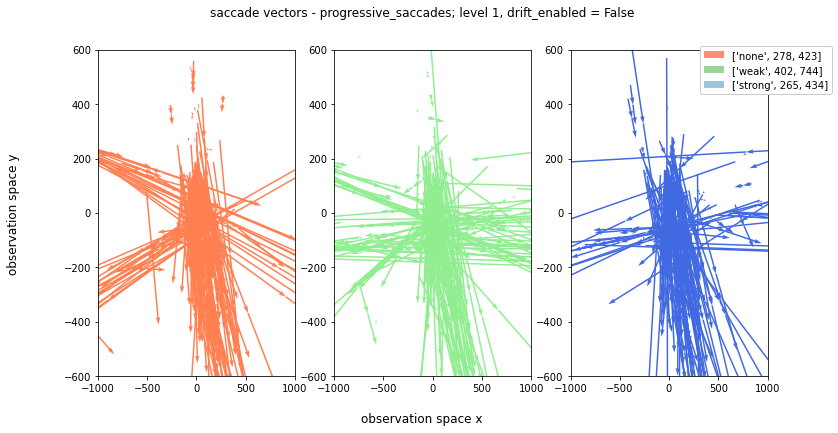

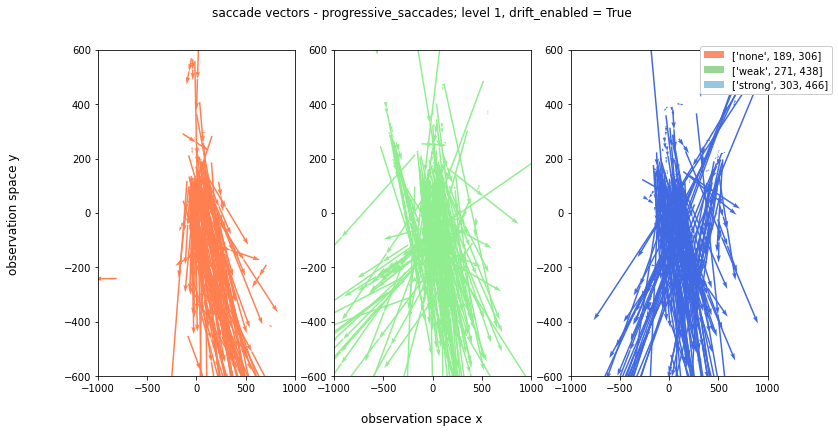

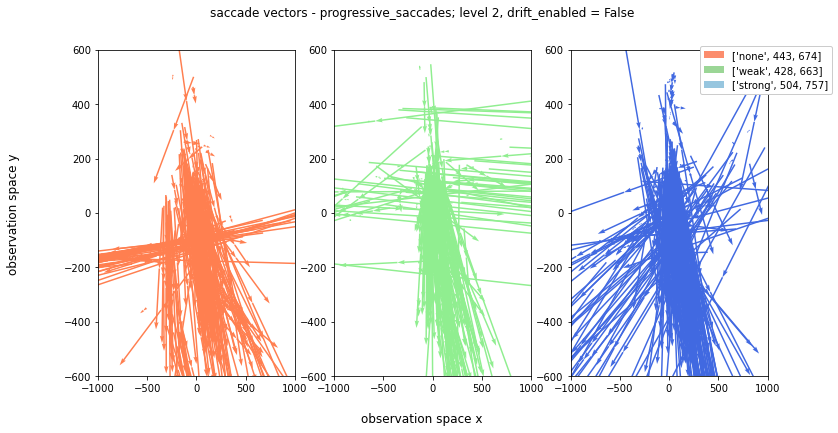

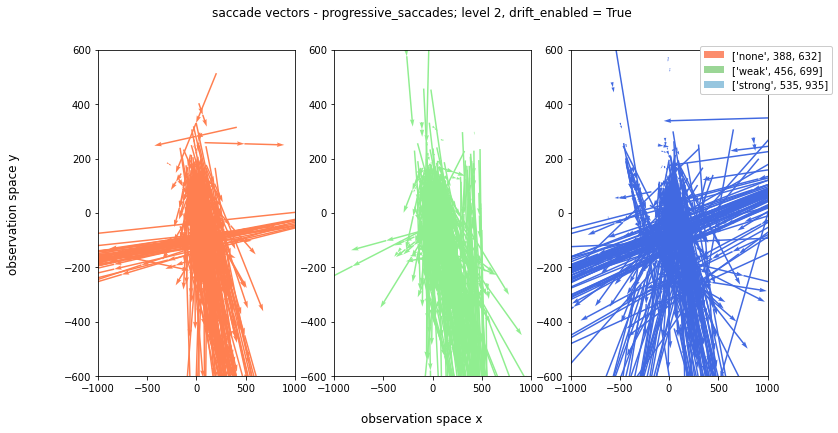

IndexError: boolean index did not match indexed array along dimension 0; dimension is 2 but corresponding boolean dimension is 1

<Figure size 864x432 with 3 Axes>

IndexError: boolean index did not match indexed array along dimension 0; dimension is 2 but corresponding boolean dimension is 1

<Figure size 864x432 with 3 Axes>

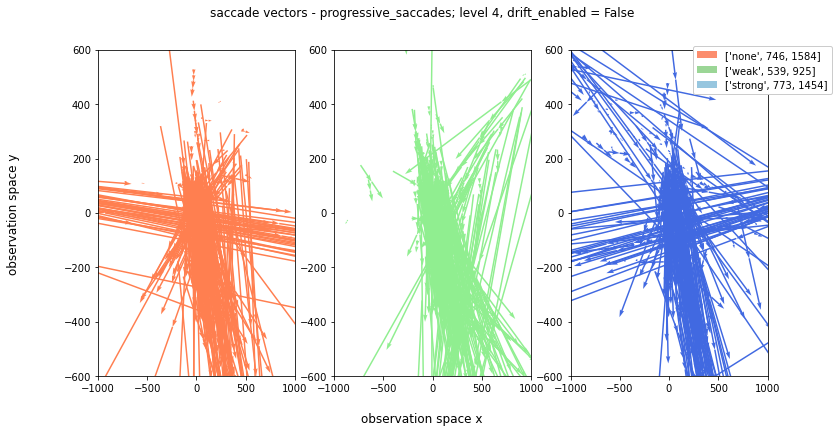

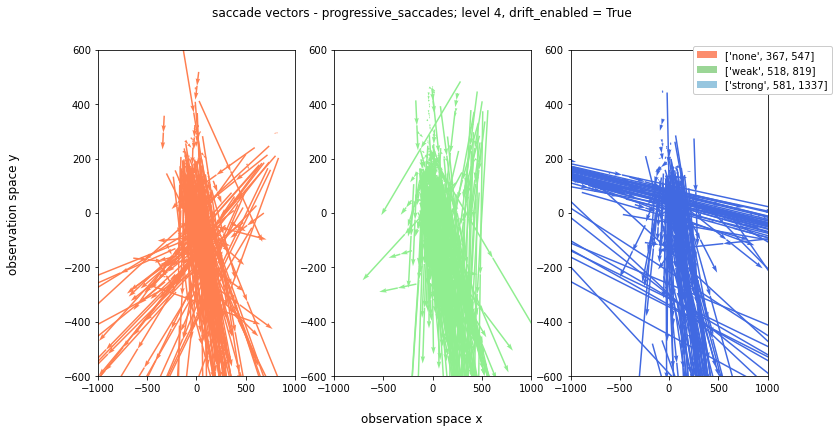

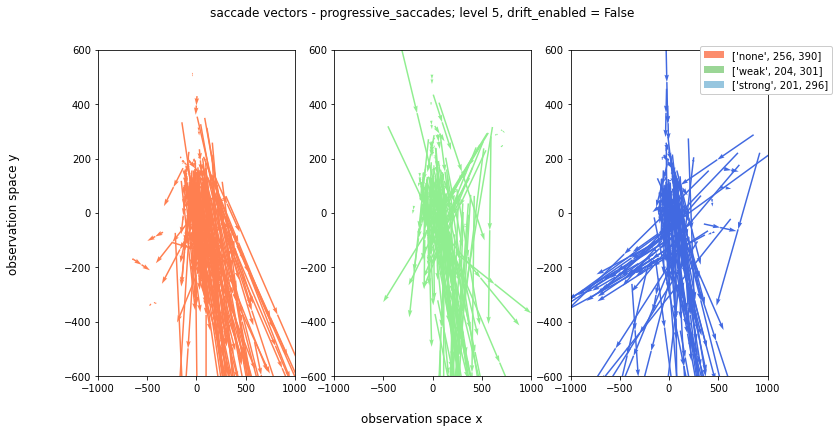

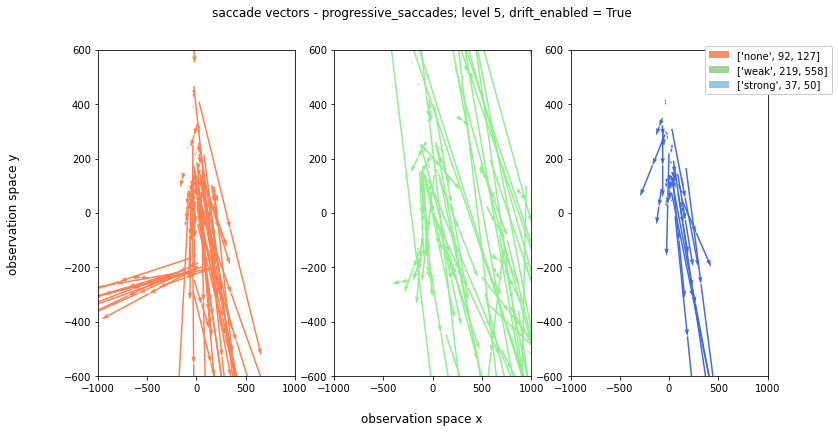

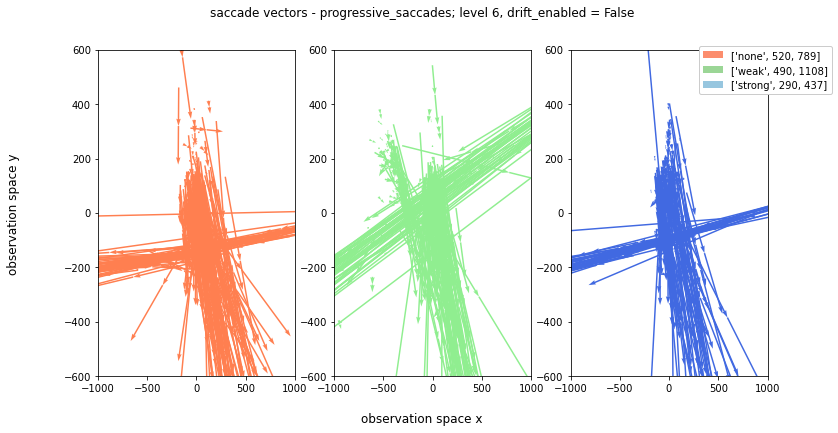

IndexError: boolean index did not match indexed array along dimension 0; dimension is 2 but corresponding boolean dimension is 1

<Figure size 864x432 with 3 Axes>

In [25]:
target_levels = [1, 2, 3, 4, 5, 6]
drift_enabled_args = [False, True]


args_list = [target_levels, drift_enabled_args]
arg_combs = list(itertools.product(*args_list))

for arg_comb in arg_combs:
    
    target_level = arg_comb[0]
    drift_enabled = arg_comb[1]

    eye_data = pd.read_csv(f'eye_data/experimental_eye_data_saccades.csv', index_col=False)
    eye_data_targetlevel = eye_data[(eye_data.level == target_level) & (eye_data.drift == str(f"{drift_enabled}")[0])]

    eye_data_none = eye_data_targetlevel[eye_data_targetlevel.input_noise == 'N']
    eye_data_weak = eye_data_targetlevel[eye_data_targetlevel.input_noise == 'W']
    eye_data_strong = eye_data_targetlevel[eye_data_targetlevel.input_noise == 'S']

    plot_saccade_vectors(eye_data_none, eye_data_weak, eye_data_strong, target_level, drift_enabled, regressive_saccades=False, safe_plot=False)


In [12]:
def plot_saccade_landing_sites(eye_data_none, eye_data_weak, eye_data_strong, level, drift_enabled, regressive_saccades=False, safe_plot=False, path_to_save_folder=f"{os.getcwd()}/plots/plots_saccade_landing_site/"):    
    
    """
    :param eye_data_none: data of onput noise = none
    :param eye_data_weak: data of onput noise = weak
    :param eye_data_strong: data of onput noise = strong
    :param level: level played
    :param drift_enabled: True vs. False
    :param regressive_saccades: True vs. False; if True regressive saccades are targeted else progressive saccades
    :param safe_plot: True vs. False - determines whether plots are saved or not
    :param path_to_save_folder: path to the folder in which plots are saved in case of safe_plot=True
    IMPORTANT: The function will not raise an error if the runs aren't of the same level and drift condition. It will only consider level and drift passed for labeling
    """
    if regressive_saccades:
        saccade_type = "regressive_saccades"
    else:
        saccade_type = "progressive_saccades"
    
    fig, axs = plt.subplots(1, 3, figsize=(12, 6))  # 3 subplots
    fig.suptitle(f"saccade landing sites - {saccade_type}; level {level}, drift_enabled = {drift_enabled}")
    
    fig.supxlabel("observation space x")
    fig.supylabel("observation space y")   

    # Plotting
    colors = ["coral", "lightgreen", "royalblue"]
    colors_p = ["crimson", "green", "blue"]
    color_maps = ["Reds", "Greens", "Blues"]
    input_noise_magnitude = ["none", "weak", "strong"]
    n_saccades = [np.nan, np.nan, np.nan]
    n_target_saccades = [np.nan, np.nan, np.nan]

    counter = 0
    
    for eye_data, ax in zip([eye_data_none, eye_data_weak, eye_data_strong], axs.ravel()):
        
        # axis labels
        ax.set_xlabel(" ")
        ax.set_ylabel(" ")

        ax.set_xlim([-1500, 1500])
        ax.set_ylim([-800, 400])

        # all kinds of saccades
        saccades = eye_data[eye_data["saccadeOnset"] >= 1]
        n_saccades[counter] = len(saccades)
        # subset target saccades
        if regressive_saccades:
            target_saccades = saccades.loc[saccades["saccade_direction_y"] >= 0]
        else:
            target_saccades = saccades.loc[saccades["saccade_direction_y"] < 0]
        n_target_saccades[counter] = len(target_saccades)
        # insert saccade landing sites
        target_saccades["saccade_landing_site_x"] = target_saccades.converging_eye_x + target_saccades.saccade_direction_x
        target_saccades["saccade_landing_site_y"] = target_saccades.converging_eye_y + target_saccades.saccade_direction_y
        
        #filter for landing sites within level
        target_saccades = target_saccades[target_saccades["saccade_landing_site_x"].between(((34-20)*18), ((34+40+20)*18))]
        # edge=34, scaling=18, observation_space_x=40
        
        # draw on canvas
        heatmap = sns.kdeplot(x=target_saccades.saccade_landing_site_x,
                              y=target_saccades.saccade_landing_site_y,
                              cmap=color_maps[counter],
                              shade=True,
                              alpha=0.9,
                              bw_adjust=0.4,
                              ax=ax)
        
        #y_coord = point_estimate(progressive_saccades.saccade_landing_site_y)[0]
        #ax.axhline(y_coord, color=colors[counter])
        #x_coord = point_estimate(progressive_saccades.saccade_landing_site_x)[0]
        #ax.axvline(x_coord, color=colors[counter])
            
        counter += 1

    handles = [mpatches.Patch(facecolor=plt.cm.Reds(100), label=[input_noise_magnitude[0], n_target_saccades[0], n_saccades[0]]),
               mpatches.Patch(facecolor=plt.cm.Greens(100), label=[input_noise_magnitude[1], n_target_saccades[1], n_saccades[1]]),
               mpatches.Patch(facecolor=plt.cm.Blues(100), label=[input_noise_magnitude[2], n_target_saccades[2], n_saccades[2]])]
    fig.legend(handles=handles, loc='upper right', bbox_to_anchor=(0.98, 0.9), framealpha=1.0)
    
    if safe_plot:
        plt.savefig(f"{path_to_save_folder}saccade_landing_site_{saccade_type}_level_{level}_drift_enabled_{drift_enabled}", dpi=300)
        #plt.close()

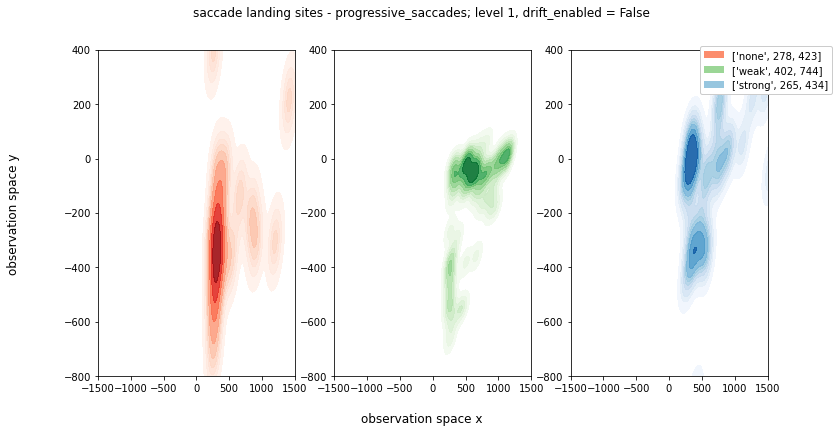

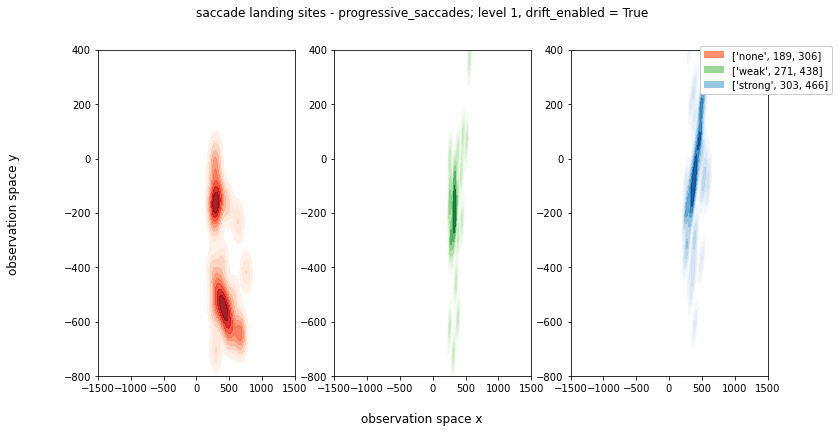

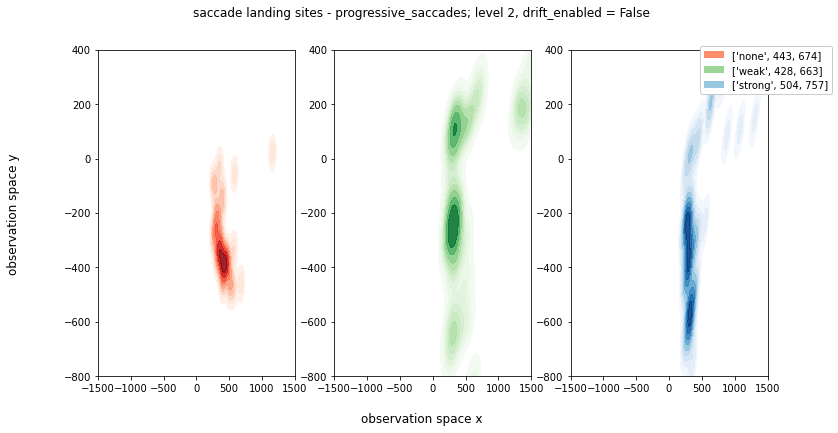

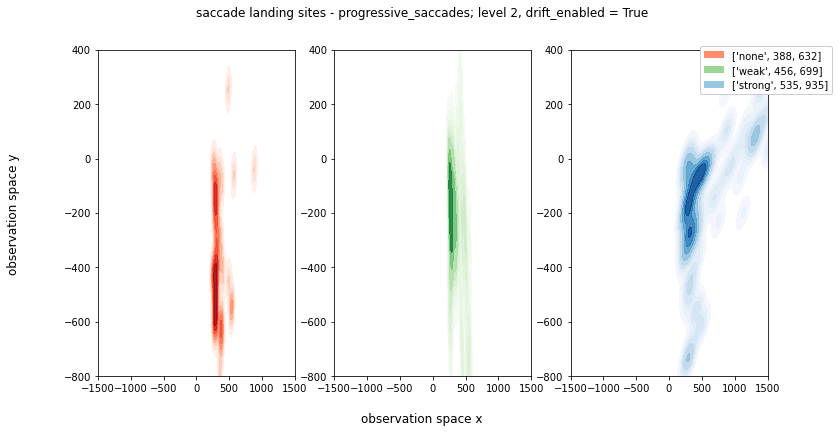

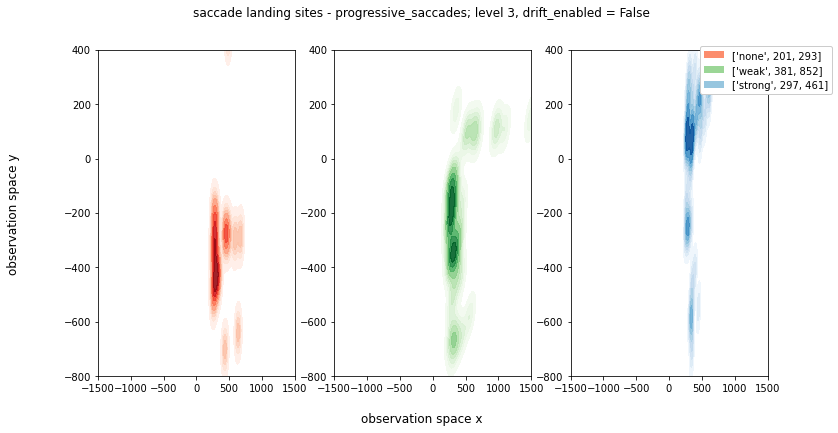

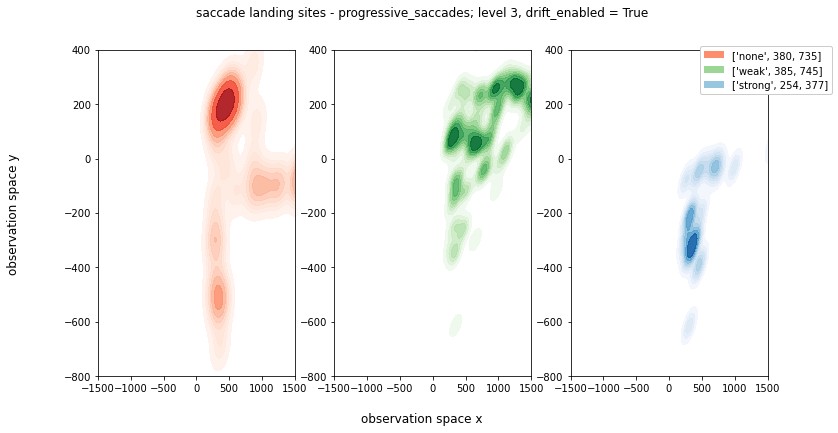

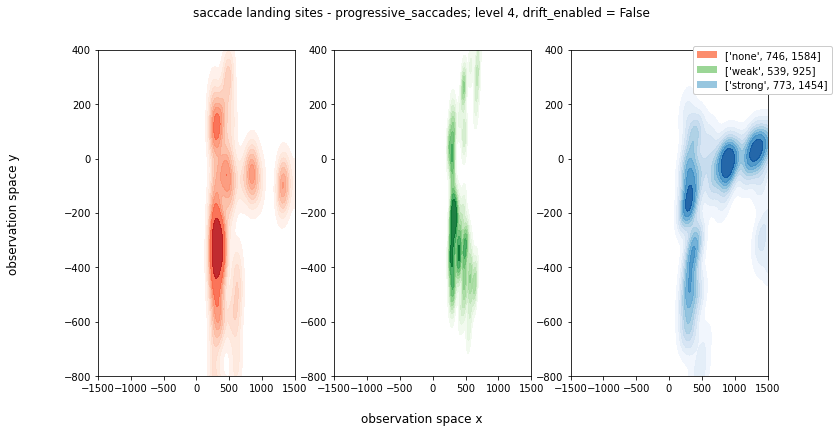

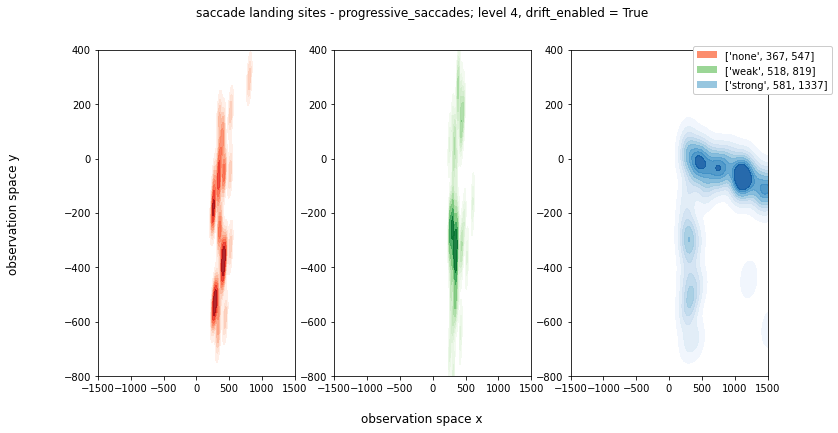

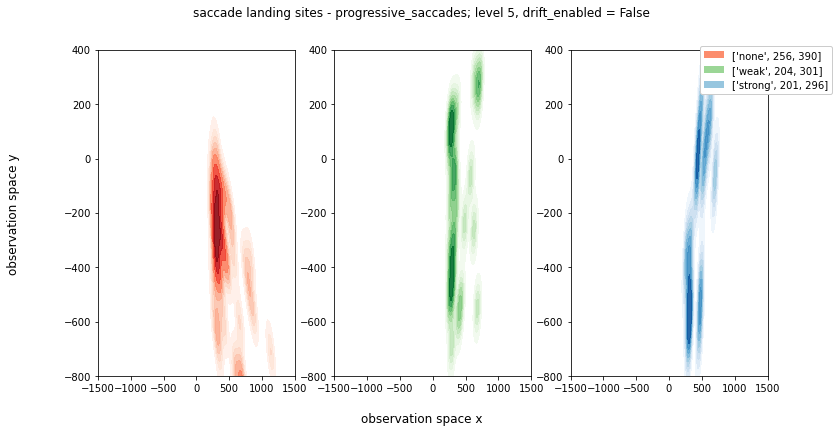

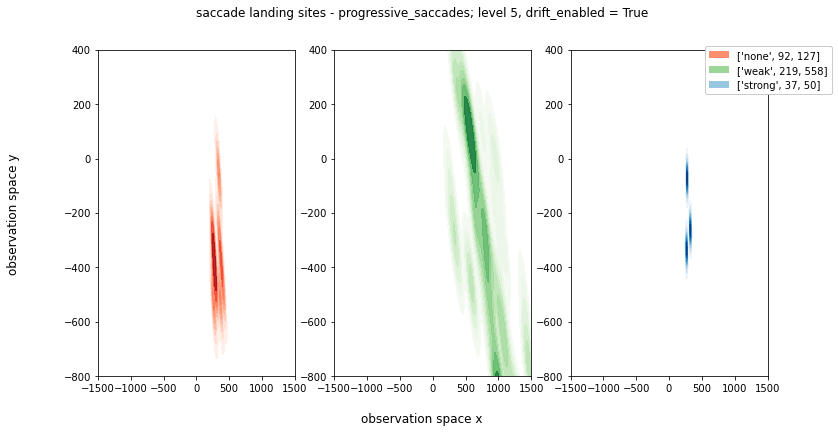

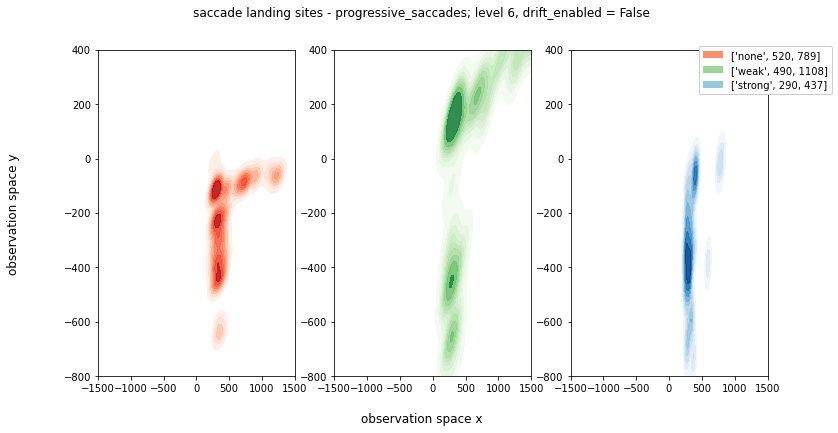

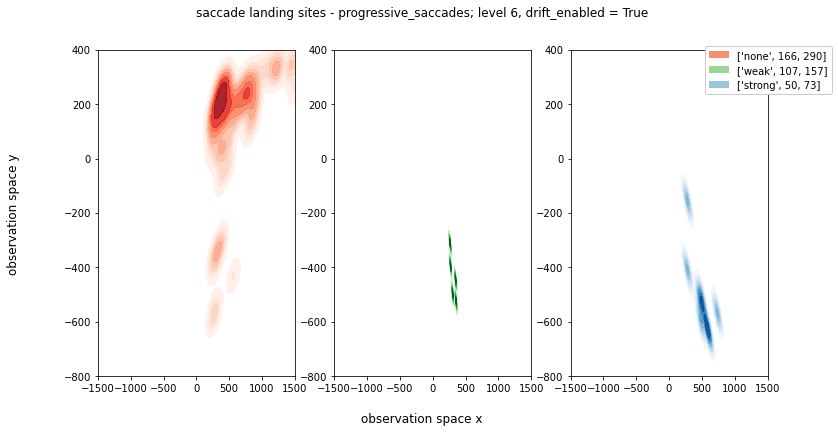

In [23]:
target_levels = [1, 2, 3, 4, 5, 6]
drift_enabled_args = [False, True]


args_list = [target_levels, drift_enabled_args]
arg_combs = list(itertools.product(*args_list))

for arg_comb in arg_combs:
    
    target_level = arg_comb[0]
    drift_enabled = arg_comb[1]

    eye_data = pd.read_csv(f'eye_data/experimental_eye_data_saccades.csv', index_col=False)
    eye_data_targetlevel = eye_data[(eye_data.level == target_level) & (eye_data.drift == str(f"{drift_enabled}")[0])]

    eye_data_none = eye_data_targetlevel[eye_data_targetlevel.input_noise == 'N']
    eye_data_weak = eye_data_targetlevel[eye_data_targetlevel.input_noise == 'W']
    eye_data_strong = eye_data_targetlevel[eye_data_targetlevel.input_noise == 'S']

    plot_saccade_landing_sites(eye_data_none, eye_data_weak, eye_data_strong, target_level, drift_enabled, regressive_saccades=False, safe_plot=False)


# Experimental data

In [33]:
root_dir = os.getcwd()

data_dir = "/experimental_data/"

target_string = "output"
target_string_eye_tracking = "eye_tracking"
done_string = "done"

successfull_runs = []

for subdir, dirs, files in os.walk(root_dir+data_dir):
    for file in files:
        if done_string in file:
            successfull_runs.append(file)

        
# triplet coding: level, drift (True vs. False), input noise (None vs. Weak vs. Strong)
# _ done vs. crashed
# experimental trial

In [34]:
successfull_runs

['EU29TT1_output_1TS_done_21.csv',
 'EU29TT1_output_1TN_done_29.csv',
 'EU29TT1_output_2TS_done_24.csv',
 'EU29TT1_output_1FW_done_12.csv',
 'EU29TT1_output_4TW_done_51.csv',
 'EU29TT1_output_0TS_done_00.csv',
 'EU29TT1_output_3TW_done_50.csv',
 'EU29TT1_output_3TN_done_41.csv',
 'EU29TT1_output_1TW_done_15.csv',
 'EU29TT1_output_2TW_done_13.csv',
 'EU29TT1_output_4FW_done_40.csv',
 'EU29TT1_output_1FN_done_10.csv',
 'EU29TT1_output_1FS_done_18.csv',
 'EU29TT1_output_4FN_done_33.csv',
 'EU29TT1_output_4FS_done_39.csv',
 'EU29TT1_output_6FS_done_17.csv',
 'EU29TT1_output_3FS_done_19.csv',
 'EU29TT1_output_6TN_done_45.csv',
 'EU29TT1_output_2FS_done_14.csv',
 'EU29TT1_output_2FN_done_08.csv',
 'EU29TT1_output_3FN_done_16.csv',
 'EU29TT1_output_6FW_done_46.csv',
 'EU29TT1_output_5FS_done_00.csv',
 'EU29TT1_output_5FW_done_42.csv',
 'EU29TT1_output_5FN_done_35.csv',
 'EU29TT1_output_2FW_done_52.csv',
 'EU29TT1_output_6FN_done_26.csv',
 'EU29TT1_output_3FW_done_38.csv',
 'EU29TT1_output_4TS

split successfull_runs by _ and get code ([0]) of trial ([-1]; - cut of .csv). Then use this to read eye_tracking data.

In [35]:
snippets = []

for file_name in successfull_runs:
    temp = file_name.split("_")
    code = temp[0]
    exp_trial = temp[-1]
    exp_trial = exp_trial[:2]  # cut off .csv
    
    snippets.append([code, exp_trial])

In [36]:
snippets

[['EU29TT1', '21'],
 ['EU29TT1', '29'],
 ['EU29TT1', '24'],
 ['EU29TT1', '12'],
 ['EU29TT1', '51'],
 ['EU29TT1', '00'],
 ['EU29TT1', '50'],
 ['EU29TT1', '41'],
 ['EU29TT1', '15'],
 ['EU29TT1', '13'],
 ['EU29TT1', '40'],
 ['EU29TT1', '10'],
 ['EU29TT1', '18'],
 ['EU29TT1', '33'],
 ['EU29TT1', '39'],
 ['EU29TT1', '17'],
 ['EU29TT1', '19'],
 ['EU29TT1', '45'],
 ['EU29TT1', '14'],
 ['EU29TT1', '08'],
 ['EU29TT1', '16'],
 ['EU29TT1', '46'],
 ['EU29TT1', '00'],
 ['EU29TT1', '42'],
 ['EU29TT1', '35'],
 ['EU29TT1', '52'],
 ['EU29TT1', '26'],
 ['EU29TT1', '38'],
 ['EU29TT1', '34'],
 ['EU29TT1', '30'],
 ['EU29TT1', '03'],
 ['EU29TT1', '09'],
 ['AM19EA1', '26'],
 ['AM19EA1', '53'],
 ['AM19EA1', '17'],
 ['AM19EA1', '00'],
 ['AM19EA1', '11'],
 ['AM19EA1', '12'],
 ['AM19EA1', '23'],
 ['AM19EA1', '10'],
 ['AM19EA1', '20'],
 ['AM19EA1', '05'],
 ['AM19EA1', '01'],
 ['AM19EA1', '52'],
 ['AM19EA1', '00'],
 ['AM19EA1', '46'],
 ['AM19EA1', '04'],
 ['AM19EA1', '38'],
 ['AM19EA1', '25'],
 ['AM19EA1', '39'],


In [37]:
temp_df = pd.DataFrame(snippets, columns = ['code', 'trial'])
temp_df

code trial
0    EU29TT1    21
1    EU29TT1    29
2    EU29TT1    24
3    EU29TT1    12
4    EU29TT1    51
..       ...   ...
374  LA22KK1    00
375  LA22KK1    47
376  LA22KK1    06
377  LA22KK1    02
378  LA22KK1    36

[379 rows x 2 columns]

In [38]:
# filter the content for trials in temp df
eye_data_successfull_runs = pd.DataFrame()


for id_code in np.unique(temp_df.code):
    successfull_runs = list(temp_df.loc[temp_df['code'] == id_code].trial)
    
    path = root_dir + data_dir + str(id_code) + "/eye_data"
    for subdir, dirs, files in os.walk(path):
        for data_file in files:
            if ".csv" in str(data_file):

                temp = str(data_file).split("_")
                # extract features of run from file_name coding
                level = temp[4][0]
                drift = temp[4][1]
                input_noise = temp[4][2]
                exp_trial = temp[-1]
                exp_trial = exp_trial[:2]
                # check for trial number of successfull trials
                #print(exp_trial, successfull_runs)
                if exp_trial in successfull_runs:

                    #f"experimental_data/{id_code}/eye_data/{data_file}"
                    temp_data = pre_process_eye_data(pd.read_csv((f"experimental_data/{id_code}/eye_data/{data_file}"), index_col=False))
                    temp_data["ID"] = id_code
                    temp_data["level"] = level
                    temp_data["drift"] = drift
                    temp_data["input_noise"] = input_noise

                    eye_data_successfull_runs = pd.concat([eye_data_successfull_runs, temp_data])


In [39]:
eye_data_successfull_runs

TimeTag    LeftEyeX    LeftEyeY  LeftPupilDiameter   RightEyeX  \
0       7582.4170 -579.439575 -348.829895          51.507812 -623.705078   
1       7582.4175 -579.837952 -348.992676          51.523438 -624.227905   
2       7582.4180 -579.985474 -348.792053          51.531250 -624.473206   
3       7582.4185 -580.206238 -348.657227          51.527344 -624.370728   
4       7582.4190 -580.604370 -348.941895          51.511719 -623.931030   
...           ...         ...         ...                ...         ...   
117102  9695.2400         NaN         NaN        9999.000000         NaN   
117103  9695.2405         NaN         NaN        9999.000000         NaN   
117104  9695.2410         NaN         NaN        9999.000000         NaN   
117105  9695.2415         NaN         NaN        9999.000000         NaN   
117106  9695.2420         NaN         NaN        9999.000000         NaN   

         RightEyeY  RightPupilDiameter   DigitalIn  LeftBlink  RightBlink  \
0      -373.253418           59.289062  16777215.0        0.0         0.0   
1      -373.602966           59.292969  16777215.0        0.0         0.0   
2      -374.019409           59.289062  16777215.0        0.0         0.0   
3      -373.753784           59.324219  16777215.0        0.0         0.0   
4      -373.278259           59.355469  16777215.0        0.0         0.0   
...            ...                 ...         ...        ...         ...   
117102         NaN         9999.000000  16777215.0        1.0         1.0   
117103         NaN         9999.000000  16777215.0        1.0         1.0   
117104         NaN         9999.000000  16777215.0        1.0         1.0   
117105         NaN         9999.000000  16777215.0        1.0         1.0   
117106         NaN         9999.000000  16777215.0        1.0         1.0   

        ...  saccade_direction_y  saccade_amplitude  converging_eye_x  \
0       ...                  NaN                NaN       -601.572327   
1       ...                  NaN                NaN       -602.032928   
2       ...                  NaN                NaN       -602.229340   
3       ...                  NaN                NaN       -602.288483   
4       ...                  NaN                NaN       -602.267700   
...     ...                  ...                ...               ...   
117102  ...                  NaN                NaN               NaN   
117103  ...                  NaN                NaN               NaN   
117104  ...                  NaN                NaN               NaN   
117105  ...                  NaN                NaN               NaN   
117106  ...                  NaN                NaN               NaN   

        converging_eye_y  converging_eye_x_adjusted  \
0            -361.041656                 358.427673   
1            -361.297821                 357.967072   
2            -361.405731                 357.770660   
3            -361.205505                 357.711517   
4            -361.110077                 357.732300   
...                  ...                        ...   
117102               NaN                        NaN   
117103               NaN                        NaN   
117104               NaN                        NaN   
117105               NaN                        NaN   
117106               NaN                        NaN   

        converging_eye_y_adjusted       ID  level  drift  input_noise  
0                      901.041656  EU29TT1      6      F            S  
1                      901.297821  EU29TT1      6      F            S  
2                      901.405731  EU29TT1      6      F            S  
3                      901.205505  EU29TT1      6      F            S  
4                      901.110077  EU29TT1      6      F            S  
...                           ...      ...    ...    ...          ...  
117102                        NaN  EU29TT1      4      T            W  
117103                        NaN  EU29TT1      4      T  

In [38]:
data_successfull_runs_fixations = data_successfull_runs[data_successfull_runs.fixationOnset == 1].reset_index()
#data_successfull_runs_fixations.to_csv('experimental_eye_data_fixations.csv', sep=',')
data_successfull_runs_fixations

index    TimeTag    LeftEyeX     LeftEyeY  LeftPupilDiameter  \
0         362  8555.6925  153.147766   280.140991          51.062500   
1        3010  8557.0165  -61.182617     3.833374          57.843750   
2        3485  8557.2540   -6.799438   220.455322          55.980469   
3        3902  8557.4625  -17.254700   282.880615          51.070312   
4        4835  8557.9290   -6.512329  -155.344238          55.539062   
...       ...        ...         ...          ...                ...   
49885  111203  5879.5690  -39.692078   204.333008          51.875000   
49886  116305  5882.1200 -404.651306 -1445.709839          75.773438   
49887  116410  5882.1725 -413.504578 -1455.393555          76.140625   
49888  116716  5882.3255 -417.064087 -1465.835938          76.664062   
49889  116991  5882.4630 -371.812225 -1504.063599          77.992188   

        RightEyeX    RightEyeY  RightPupilDiameter   DigitalIn  LeftBlink  \
0      138.066833   263.747314           59.636719  16777215.0        0.0   
1      -26.071381    -5.930054           63.949219  16777215.0        0.0   
2       -5.339569   193.183472           62.375000  16777215.0        0.0   
3      -11.294189   258.508545           57.000000  16777215.0        0.0   
4       21.574677  -168.864441           60.718750  16777215.0        0.0   
...           ...          ...                 ...         ...        ...   
49885   -5.561401   168.696655           50.789062  16777215.0        0.0   
49886 -437.768127 -1547.708496           71.863281  16777215.0        0.0   
49887 -435.679962 -1546.424194           72.390625  16777215.0        0.0   
49888 -458.101501 -1519.178345           73.531250  16777215.0        0.0   
49889 -345.491058 -1512.804199           78.335938  16777215.0        0.0   

       ...  saccade_direction_y  saccade_amplitude  converging_eye_x  \
0      ...                  NaN                NaN        145.607300   
1      ...                  NaN                NaN        -43.626999   
2      ...                  NaN                NaN         -6.069504   
3      ...                  NaN                NaN        -14.274445   
4      ...                  NaN                NaN          7.531174   
...    ...                  ...                ...               ...   
49885  ...                  NaN                NaN        -22.626740   
49886  ...                  NaN                NaN       -421.209717   
49887  ...                  NaN                NaN       -424.592270   
49888  ...                  NaN                NaN       -437.582794   
49889  ...                  NaN                NaN       -358.651642   

       converging_eye_y  converging_eye_x_adjusted  converging_eye_y_adjusted  \
0            271.944153                1105.607300                 268.055847   
1             -1.048340                 916.373001                 541.048340   
2            206.819397                 953.930496                 333.180603   
3            270.694580                 945.725555                 269.305420   
4           -162.104340                 967.531174                 702.104340   
...                 ...                        ...                        ...   
49885        186.514832                 937.373260                 353.485168   
49886      -1496.709167                 538.790283                2036.709167   
49887      -1500.908875                 535.407730                2040.908875   
49888      -1492.507141                 522.417206                2032.507141   
49889      -1508.433899                 601.348358                2048.433899   

            ID  level  drift  input_noise  
0      AE07EM1      2      T            N  
1      AE07EM1      2      T            N  
2      AE07EM1      2      T            N  
3      AE07EM1      2      T            N  
4      AE07EM1      2      T            N  
...        ...    ...    ...          ...  
49885  VE21IR1      4      F            N  
49886  VE21IR1      4      F

In [36]:
data_successfull_runs_fixations.groupby(["level", "drift", "input_noise"]).fixation_duration.mean()

level  drift  input_noise
1      F      N              0.181390
              S              0.233991
              W              0.185051
       T      N              0.334169
              S              0.198964
              W              0.282282
2      F      N              0.306268
              S              0.224205
              W              0.272824
       T      N              0.308337
              S              0.244530
              W              0.308496
3      F      N              0.256494
              S              0.317693
              W              0.294754
       T      N              0.164919
              S              0.245825
              W              0.239144
4      F      N              0.237551
              S              0.197917
              W              0.260584
       T      N              0.250494
              S              0.348798
              W              0.286312
5      F      N              0.293129
              S         

In [32]:
import itertools

# extract all unique levels of varibales
levels = data_successfull_runs.level.unique()
drift_enabled_args = data_successfull_runs.drift.unique()
input_noise_args = data_successfull_runs.input_noise.unique()

# every possible combination of level, drift, and input_noise
args_list = [levels, drift_enabled_args, input_noise_args]
arg_combs = list(itertools.product(*args_list))

# then loop over all unique id_codes
print(arg_combs)

[('2', 'T', 'N'), ('2', 'T', 'W'), ('2', 'T', 'S'), ('2', 'F', 'N'), ('2', 'F', 'W'), ('2', 'F', 'S'), ('5', 'T', 'N'), ('5', 'T', 'W'), ('5', 'T', 'S'), ('5', 'F', 'N'), ('5', 'F', 'W'), ('5', 'F', 'S'), ('4', 'T', 'N'), ('4', 'T', 'W'), ('4', 'T', 'S'), ('4', 'F', 'N'), ('4', 'F', 'W'), ('4', 'F', 'S'), ('6', 'T', 'N'), ('6', 'T', 'W'), ('6', 'T', 'S'), ('6', 'F', 'N'), ('6', 'F', 'W'), ('6', 'F', 'S'), ('3', 'T', 'N'), ('3', 'T', 'W'), ('3', 'T', 'S'), ('3', 'F', 'N'), ('3', 'F', 'W'), ('3', 'F', 'S'), ('1', 'T', 'N'), ('1', 'T', 'W'), ('1', 'T', 'S'), ('1', 'F', 'N'), ('1', 'F', 'W'), ('1', 'F', 'S')]


In [33]:
arg_comb = ''.join(arg_combs[0][0:3])
arg_comb

'2TN'

# Plot experimental data

In [ ]:
# 6 possible levels 
N_levels = 6  # 1:6, therefore np.arange(1, N_levels+1)
drift_enabled_args = ['T', 'F']  # T: True vs. F: False
input_noise_args = ['N', 'W', 'S']  # none vs. weak vs. strong

for level_n in np.arange(1, N_levels+1):
    for drift_arg in drift_enabled_args:
        temp_data = eye_data_complete.loc[(eye_data_complete.level == str(level_n)) & (eye_data_complete.drift == drift_arg)]
        
        # create individual dataFrames for each level of input_noise
        temp_data_none = temp_data.loc[temp_data.input_noise == 'N']
        temp_data_weak = temp_data.loc[temp_data.input_noise == 'W']
        temp_data_strong = temp_data.loc[temp_data.input_noise == 'S']
        
        # call plotting function
        #plot_fixation_location_kde(temp_data_none, temp_data_weak, temp_data_strong, level=level_n, drift_enabled=drift_arg, safe_plot=True)
        #plot_saccade_amplitudes(temp_data_none, temp_data_weak, temp_data_strong, level=level_n, drift_enabled=drift_arg, safe_plot=True)
        #plot_saccade_landing_sites(temp_data_none, temp_data_weak, temp_data_strong, level=level_n, drift_enabled=drift_arg, safe_plot=True)    
        #plot_saccade_amplitude_kde(temp_data_none, temp_data_weak, temp_data_strong, level=level_n, drift_enabled=drift_arg, safe_plot=True)

In [13]:
def plot_saccade_amplitude_kde(eye_data_none, eye_data_weak, eye_data_strong, level, drift_enabled, regressive_saccades=False, safe_plot=False, path_to_save_folder=f"{os.getcwd()}/plots/plots_saccade_amplitude_kde/"):    
    
    """
    :param eye_data_none: data of onput noise = none
    :param eye_data_weak: data of onput noise = weak
    :param eye_data_strong: data of onput noise = strong
    :param level: level played
    :param drift_enabled: True vs. False
    :param regressive_saccades: True vs. False; if True regressive saccades are targeted else progressive saccades
    :param safe_plot: True vs. False - determines whether plots are saved or not
    :param path_to_save_folder: path to the folder in which plots are saved in case of safe_plot=True
    IMPORTANT: The function will not raise an error if the runs aren't of the same level and drift condition. It will only consider level and drift passed for labeling
    """   
    if regressive_saccades:
        saccade_type = "regressive_saccades"
    else:
        saccade_type = "progressive_saccades"
    # Grid
    fig, ax = plt.subplots(figsize=(12, 6))
    ax.set_title(f"Densities of saccade amplitudes - {saccade_type}; level {level} (drift enabled = {drift_enabled})", fontdict={"fontweight": "bold"})


    # axis labels
    ax.set_xlabel("saccade amplitude")
    ax.set_ylabel("Density")

    # plot boundaries:
    lbound = 0
    ubound = 1000
    
    ax.set_xlim([lbound, ubound])

    xaxis = np.linspace(lbound, ubound, 11)
    ax.set_xticks(xaxis)
    
    # Plotting parameters
    colors = ["coral", "lightgreen", "royalblue"]
    colors_p = ["crimson", "green", "blue"]
    color_maps = ["Reds", "Greens", "Blues"]
    input_noise_magnitude = ["none", "weak", "strong"]
    n_saccades = [np.nan, np.nan, np.nan]
    n_target_saccades = [np.nan, np.nan, np.nan]
    
    counter = 0
    
    for temp_eye_data in [eye_data_none, eye_data_weak, eye_data_strong]:
        # reducing data to only respective events of interest (saccade onsets) & filter enormous saccade amplitudes
        saccades = temp_eye_data[(temp_eye_data["saccadeOnset"] == 1.0) & (temp_eye_data["saccade_amplitude"] < 1000)]
        
        # subset target saccades
        if regressive_saccades:
            saccades = saccades.loc[saccades["saccade_direction_y"] >= 0]
        else:
            saccades = saccades.loc[saccades["saccade_direction_y"] < 0]
        
        n_saccades[counter] = len(saccades)
        ## insert saccade landing sites
        saccades["saccade_landing_site_x"] = saccades.converging_eye_x + saccades.saccade_direction_x
        saccades["saccade_landing_site_y"] = saccades.converging_eye_y + saccades.saccade_direction_y
        
        #filter for landing sites within level
        saccades = saccades[saccades["saccade_landing_site_x"].between(((34-20)*18), ((34+40+20)*18))]
        # edge=34, scaling=18, observation_space_x=40
        

        # define arrays of saccade amplitudes for respective data
        eye_data_array = np.asarray(saccades.saccade_amplitude)

        # compute hpdi (I went for the smallest interval which contains 25% of the mass)
        eye_data_hpdi_bounds = az.hdi(eye_data_array, 0.25)

        # instatiate KDEs
        kde_init = np.linspace(lbound, ubound, 100)

        eye_data_kde = st.gaussian_kde(eye_data_array)


        # draw KDE

        ax.plot(kde_init, eye_data_kde(kde_init), color=colors[counter], label=input_noise_magnitude[counter])

        # define dataframe for points of eye_data ( now because we can retrieve y-axis limits at this point)
        #y_max = ax.get_ylim()[1]  # 0: bottom; 1: top
        #eye_data_points = {'x': eye_data_array, 'y': [y_max/99]*len(eye_data_array)}  # y_max/99 to plot these a bit above input data points
        #eye_data_points = pd.DataFrame(data=eye_data_points)
        #ax.scatter(eye_data_points.x, eye_data_points.y, marker=".", color=colors[counter])


        # HPDIs:
        point_estimate_eye_data = point_estimate(saccades.time_tag)
        #plt.vlines(point_estimate_eye_data[0], ymin=0, ymax=point_estimate_eye_data[1], color=colors[counter])
        
        counter += 1
        
    ax.legend()

    if safe_plot:
        plt.savefig(f"{path_to_save_folder}saccade_amplitude_kde_{saccade_type}_level_{level}_drift_enabled_{drift_enabled}", dpi=300)
        #plt.close()

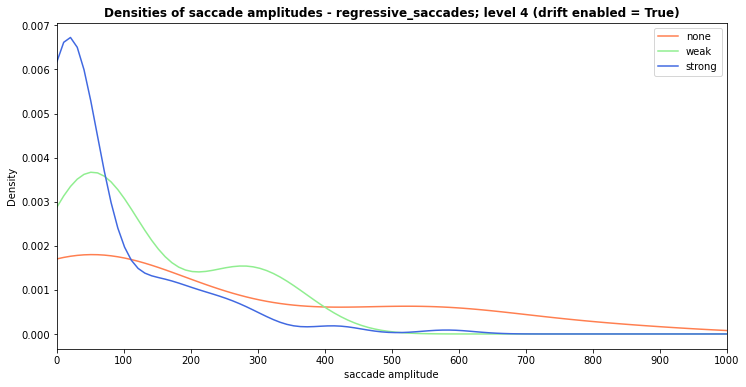

In [61]:
target_level = 4
drift_enabled = True

eye_data = pd.read_csv(f'eye_data/experimental_eye_data_saccades.csv', index_col=False)
eye_data_targetlevel = eye_data[(eye_data.level == target_level) & (eye_data.drift == str(f"{drift_enabled}")[0])]

eye_data_none = eye_data_targetlevel[eye_data_targetlevel.input_noise == 'N']
eye_data_weak = eye_data_targetlevel[eye_data_targetlevel.input_noise == 'W']
eye_data_strong = eye_data_targetlevel[eye_data_targetlevel.input_noise == 'S']

plot_saccade_amplitude_kde(eye_data_none, eye_data_weak, eye_data_strong, target_level, drift_enabled, regressive_saccades=True, safe_plot=False)


In [162]:
#target_level = 4
drift_enabled = True

eye_data = pd.read_csv(f'eye_data/experimental_eye_data_fixations.csv', index_col=False)

eye_data['level_difficulty'] = (eye_data.level // 2) + (eye_data.level % 2 > 0)

# categorical sorting
eye_data['drift'] = pd.Categorical(eye_data['drift'], ["F", "T"])
eye_data['input_noise'] = pd.Categorical(eye_data['input_noise'], ["N", "W", "S"])

eye_data.groupby(["level_difficulty", "drift", "input_noise", "exploring_fixation"]).fixation_duration.agg(['mean', 'std'])

mean       std
level_difficulty drift input_noise exploring_fixation                    
1                F     N           0                   0.233455  0.325011
                                   1                   0.310920  0.342292
                       W           0                   0.225355  0.365628
                                   1                   0.300486  0.398279
                       S           0                   0.205087  0.326703
                                   1                   0.344262  0.635132
                 T     N           0                   0.315790  0.412733
                                   1                   0.319231  0.371488
                       W           0                   0.304535  0.395374
                                   1                   0.272278  0.310537
                       S           0                   0.226816  0.309328
                                   1                   0.231487  0.280688
2                F     N           0                   0.236580  0.318607
                                   1                   0.290608  0.276592
                       W           0                   0.272652  0.324915
                                   1                   0.261445  0.279139
                       S           0                   0.235753  0.339107
                                   1                   0.179682  0.268706
                 T     N           0                   0.204473  0.287013
                                   1                   0.285775  0.304004
                       W           0                   0.263218  0.360804
                                   1                   0.329740  0.364706
                       S           0                   0.294181  0.369484
                                   1                   0.348322  0.351560
3                F     N           0                   0.251308  0.331649
                                   1                   0.307017  0.382562
                       W           0                   0.234960  0.305244
                                   1                   0.162683  0.258714
                       S           0                   0.270087  0.305132
                                   1                   0.358348  0.429347
                 T     N           0                   0.253463  0.316825
                                   1                   0.356919  0.417782
                       W           0                   0.176829  0.256644
                                   1                   0.075528  0.170217
                       S           0                   0.337655  0.288843
                                   1                   0.324875  0.235621

In [14]:
def plot_fixation_duration(eye_data_none, eye_data_weak, eye_data_strong, level, drift_enabled, exploring_fixations=True, safe_plot=False, path_to_save_folder=f"{os.getcwd()}/plots/plota_fixation_duration/"):    
    
    """
    :param eye_data_none: data of onput noise = none
    :param eye_data_weak: data of onput noise = weak
    :param eye_data_strong: data of onput noise = strong
    :param level: level played
    :param drift_enabled: True vs. False
    :param exploring_fixations: True vs. False; if True progressive fixations are considered, else resting fixations
    :param safe_plot: True vs. False - determines whether plots are saved or not
    :param path_to_save_folder: path to the folder in which plots are saved in case of safe_plot=True
    IMPORTANT: The function will not raise an error if the runs aren't of the same level and drift condition. It will only consider level and drift passed for labeling
    """
    
    if exploring_fixations:
        fixation_type = "exploring_fixations"
    else:
        fixation_type = "resting_fixations"
    
    fig, ax = plt.subplots(figsize=(12, 6))
    
    ax.set_title(f"fixation durations - {fixation_type}; level {level}, drift_enabled = {drift_enabled}", fontdict={"fontweight": "bold"})

    # axis labels
    ax.set_xlabel("input noise magnitude")
    ax.set_ylabel("fixation duration (in s)")

    ax.set_xlim([-70, 70])
    ax.set_xticks([-50, 0, 50])
    ax.set_xticklabels(["NaN", "weak", "strong"])

    # Plotting
    colors = ["coral", "lightgreen", "royalblue"]
    colors_p = ["crimson", "green", "blue"]
    color_maps = ["Reds", "Greens", "Blues"]
    input_noise_magnitude = ["none", "weak", "strong"]
    offset = [-50, 0, 50]
    n_fixations = [np.nan, np.nan, np.nan]
    n_target_fixations = [np.nan, np.nan, np.nan]

    counter = 0

    for eye_data in [eye_data_none, eye_data_weak, eye_data_strong]:

        # all kinds of saccades
        # only consider the ones whichs amplitude is below 800 (arbitrarily chosen - saccades out of screen)
        fixations = eye_data[eye_data["fixationOnset"] >= 1]
        n_fixations[counter] = len(fixations)
        plot_labels = [offset[counter]]* len(fixations)
        fixations["plot_label"] = [offset[counter]]* len(fixations)
        # subset target fixations
        if exploring_fixations:
            target_fixations = fixations.loc[fixations["exploring_fixation"] == 1]
        else:
            target_fixations = fixations.loc[fixations["exploring_fixation"] == 0]
        n_target_fixations[counter] = len(target_fixations)
        
        # draw on canvas
        ax.scatter(target_fixations.plot_label, target_fixations.fixation_duration, marker=".", color=colors_p[counter], alpha=0.3)
        
        fit_alpha, fit_loc, fit_beta = st.gamma.fit(target_fixations.fixation_duration)
        mean_gamma = fit_alpha*fit_beta
        ax.plot(offset[counter], mean_gamma, marker="_", markersize=15, color=colors_p[counter], alpha=1.0)
        # np.mean(target_fixations.fixation_duration)
        
        counter += 1

    handles = [mpatches.Patch(facecolor=plt.cm.Reds(100), label=[input_noise_magnitude[0], n_target_fixations[0], n_fixations[0]]),
               mpatches.Patch(facecolor=plt.cm.Greens(100), label=[input_noise_magnitude[1], n_target_fixations[1], n_fixations[1]]),
               mpatches.Patch(facecolor=plt.cm.Blues(100), label=[input_noise_magnitude[2], n_target_fixations[2], n_fixations[2]])]
    ax.legend(handles=handles)
    
    if safe_plot:
        plt.savefig(f"{path_to_save_folder}fixation_duration_{fixation_type}_level_{level}_drift_enabled_{drift_enabled}", dpi=300)
        #plt.close()

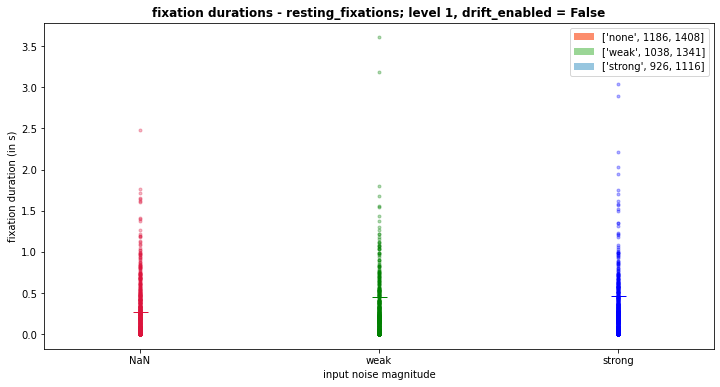

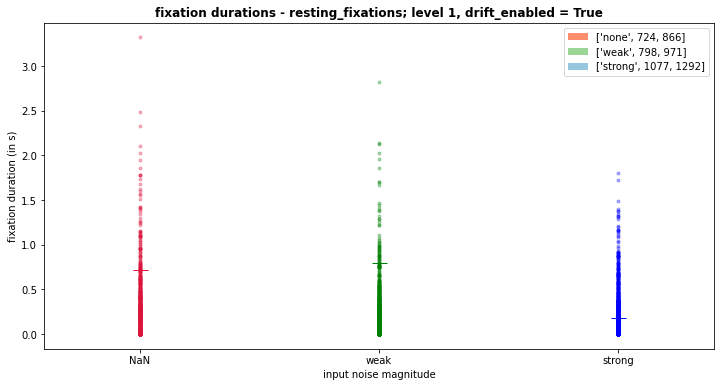

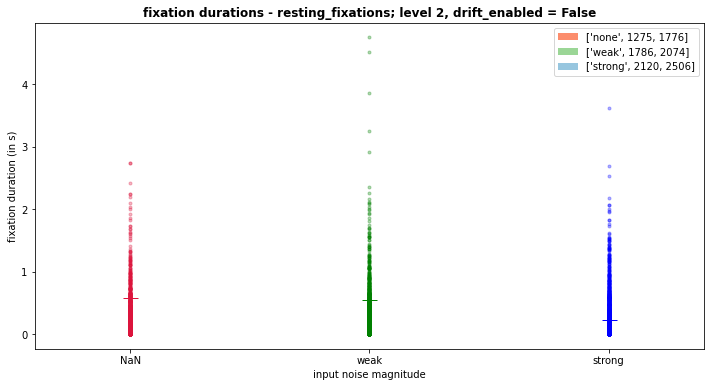

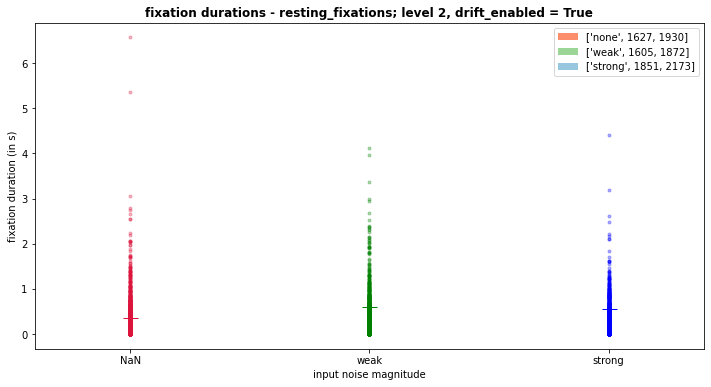

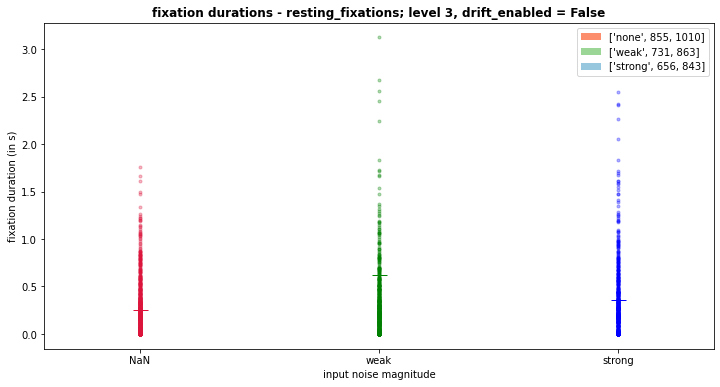

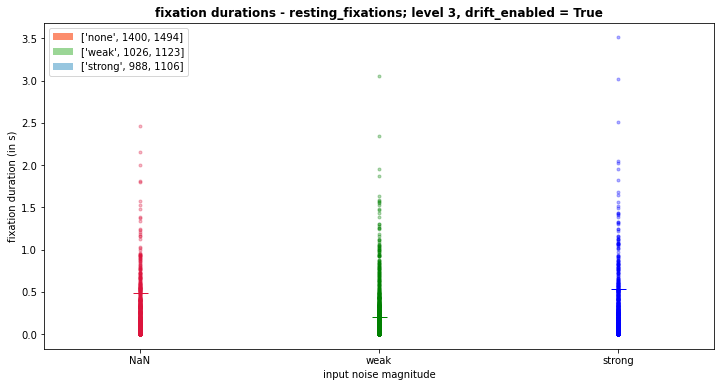

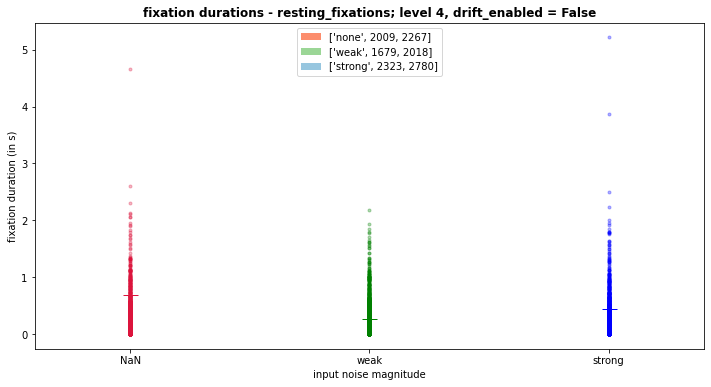

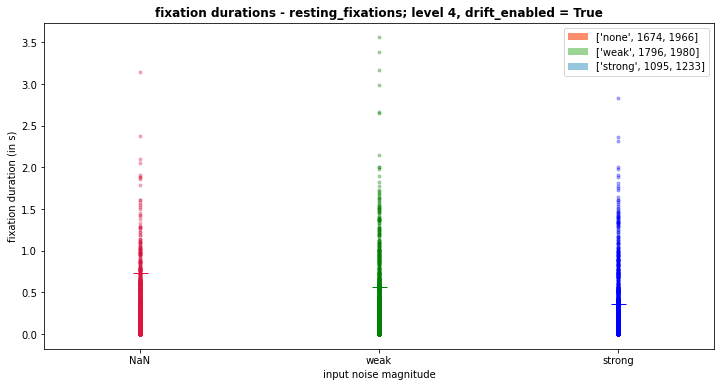

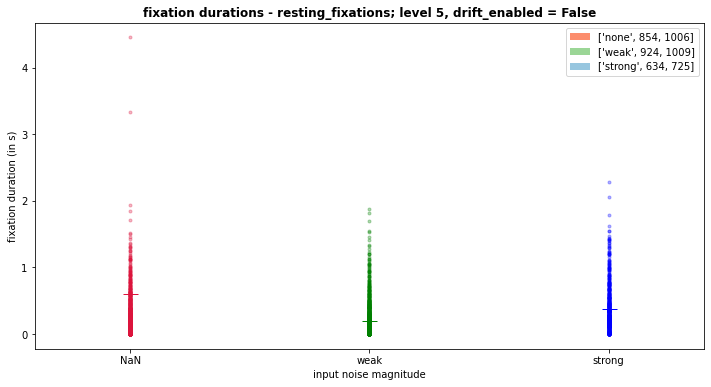

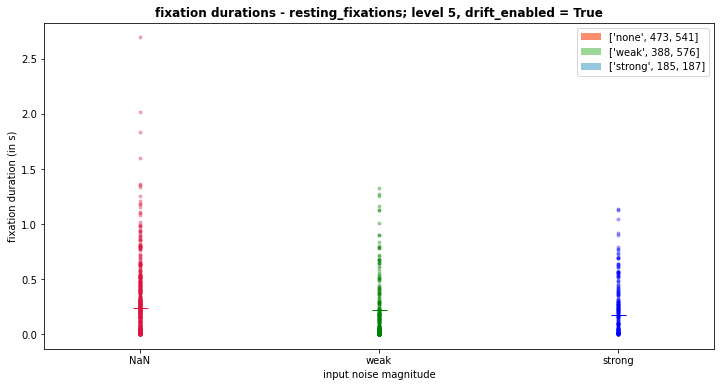

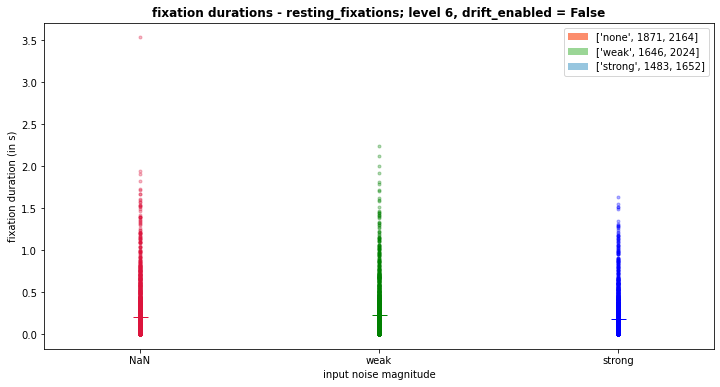

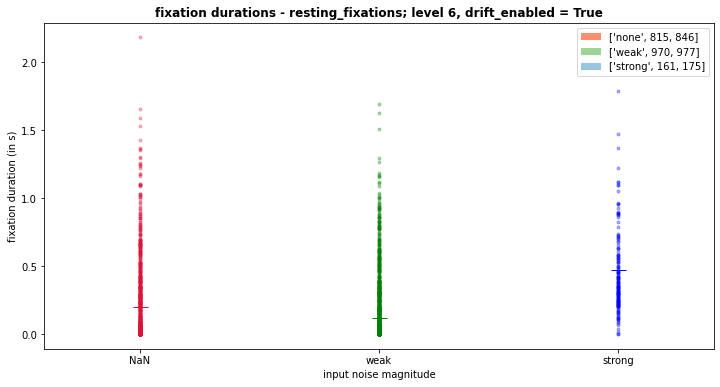

In [24]:
target_levels = [1, 2, 3, 4, 5, 6]
drift_enabled_args = [False, True]


args_list = [target_levels, drift_enabled_args]
arg_combs = list(itertools.product(*args_list))

for arg_comb in arg_combs:
    
    target_level = arg_comb[0]
    drift_enabled = arg_comb[1]

    eye_data = pd.read_csv(f'eye_data/experimental_eye_data_fixations.csv', index_col=False)
    eye_data_targetlevel = eye_data[(eye_data.level == target_level) & (eye_data.drift == str(f"{drift_enabled}")[0])]

    eye_data_none = eye_data_targetlevel[eye_data_targetlevel.input_noise == 'N']
    eye_data_weak = eye_data_targetlevel[eye_data_targetlevel.input_noise == 'W']
    eye_data_strong = eye_data_targetlevel[eye_data_targetlevel.input_noise == 'S']

    plot_fixation_duration(eye_data_none, eye_data_weak, eye_data_strong, target_level, drift_enabled, exploring_fixations=False, safe_plot=False)


In [ ]:
colors = ["coral", "lightgreen", "royalblue"]
colors_p = ["crimson", "green", "blue"]
color_maps = ["Reds", "Greens", "Blues"]
input_noise_magnitude = ["none", "weak", "strong"]

In [25]:
N_locations = np.arange(len(eye_data.level_difficulty.unique()))
N_locations

<AxesSubplot:xlabel='drift,input_noise'>

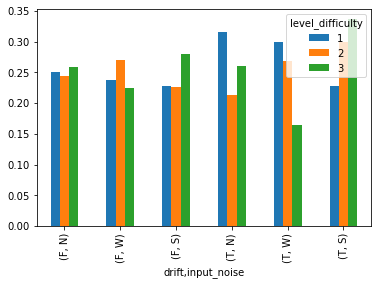

In [31]:
eye_data.groupby(["level_difficulty", "drift", "input_noise"]).fixation_duration.mean().unstack(0).plot.bar()